# Clustering to Archetypes

In [174]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import plotly.express as px
import sklearn as skl
import networkx as nx
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import kneighbors_graph
from networkx.algorithms.community import louvain_communities
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances



### loading the data

In [2]:
# ---------------------------------------------------------
# 1. Load the Base Table (The "Master List" of Players)
# ---------------------------------------------------------
project_root = "../"
data_path = project_root + "data/interim/clusters/"
base_file = 'Updating_per_year_player_features_stats.csv'
df_base = pd.read_csv(data_path + base_file)

# Ensure keys are the right type for merging
df_base['PLAYER_ID'] = df_base['PLAYER_ID'].astype(int)
df_base['SEASON'] = df_base['SEASON'].astype(str)

# Create a set of unique keys for quick lookup
base_keys = set(zip(df_base['PLAYER_ID'], df_base['SEASON']))

print(f"Base Table Loaded: {len(df_base)} rows.")
print("-" * 50)

# ---------------------------------------------------------
# 2. List of Your Auxiliary Files (From README)
# ---------------------------------------------------------
# Add your actual file names here based on your folder structure
files_to_check = [
    'full_players_defense_Overall.csv',
    'full_players_defense_2_Pointers.csv',
    'full_players_defense_3_Pointers.csv',
    'full_players_rebound_aggregated.csv',
    'full_players_shotloc.csv',
    'full_players_shottype_small.csv',
    'full_synergy_stats.csv'
]

# ---------------------------------------------------------
# 3. The "Missing Data" Auditor
# ---------------------------------------------------------
missing_report = {}

for filename in files_to_check:
    if not os.path.exists(data_path + filename):
        print(f"⚠️ File not found: {filename} (Skipping)")
        continue

    print(f"Checking {filename}...")
    
    # SPECIAL HANDLING: Shot Location (Multi-level header)
    if 'shotloc' in filename:
        # Load with 2 header rows
        df_curr = pd.read_csv(data_path + filename, header=[0, 1])
        
        # Flatten the headers: Combine "Restricted Area" + "FGM" -> "Restricted Area - FGM"
        new_cols = []
        for col in df_curr.columns:
            # col is a tuple like ('Restricted Area', 'FGM')
            # If the first level is unnamed (like for PLAYER_ID), just take the second level
            if "Unnamed" in str(col[0]):
                new_cols.append(col[1])
            else:
                new_cols.append(f"{col[0]} - {col[1]}")
        
        df_curr.columns = new_cols
        
    else:
        # Standard load for other files
        df_curr = pd.read_csv(data_path + filename)

    # Standardize Keys
    if 'PLAYER_ID' in df_curr.columns and 'SEASON' in df_curr.columns:
        df_curr['PLAYER_ID'] = df_curr['PLAYER_ID'].astype(int)
        df_curr['SEASON'] = df_curr['SEASON'].astype(str)
        
        # Perform Left Join to find what is in BASE but NOT in CURR
        # We use the indicator=True feature of pandas merge
        merged = df_base[['PLAYER_ID', 'SEASON', 'PLAYER']].merge(
            df_curr[['PLAYER_ID', 'SEASON']], 
            on=['PLAYER_ID', 'SEASON'], 
            how='left', 
            indicator=True
        )
        
        # Filter for 'left_only' (meaning it exists in base, but not in current file)
        missing_rows = merged[merged['_merge'] == 'left_only']
        
        count_missing = len(missing_rows)
        pct_missing = (count_missing / len(df_base)) * 100
        
        print(f"   -> Missing {count_missing} rows ({pct_missing:.1f}%)")
        
        if count_missing > 0:
            # Store the missing examples for you to inspect
            missing_report[filename] = missing_rows[['PLAYER', 'SEASON', 'PLAYER_ID']].head(5).values.tolist()
    else:
        print(f"   -> ❌ SKIPPING: Could not find PLAYER_ID or SEASON columns.")

print("-" * 50)
print("SAMPLE OF MISSING DATA (First 5 examples per file):")
for fname, examples in missing_report.items():
    print(f"\nIn {fname}, these players are missing:")
    for ex in examples:
        print(f"   - {ex[0]} ({ex[1]})")

Base Table Loaded: 4327 rows.
--------------------------------------------------
Checking full_players_defense_Overall.csv...
   -> Missing 0 rows (0.0%)
Checking full_players_defense_2_Pointers.csv...
   -> Missing 0 rows (0.0%)
Checking full_players_defense_3_Pointers.csv...
   -> Missing 0 rows (0.0%)
Checking full_players_rebound_aggregated.csv...
   -> Missing 201 rows (4.6%)
Checking full_players_shotloc.csv...
   -> Missing 0 rows (0.0%)
Checking full_players_shottype_small.csv...
   -> Missing 194 rows (4.5%)
Checking full_synergy_stats.csv...
   -> Missing 0 rows (0.0%)
--------------------------------------------------
SAMPLE OF MISSING DATA (First 5 examples per file):

In full_players_rebound_aggregated.csv, these players are missing:
   - Payton Pritchard (2020-21)
   - Dario Šarić (2017-18)
   - Stanley Umude (2022-23)
   - Mike Conley (2024-25)
   - Mike Conley (2021-22)

In full_players_shottype_small.csv, these players are missing:
   - Braxton Key (2023-24)
   - Jesse

In [3]:
# ---------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------
base_file = 'Updating_per_year_player_features_stats.csv'

# Define your list of files to merge
# KEY STEP: Map specific files to a "Prefix" to avoid collision
# Use None if no prefix is needed (e.g., for unique tables)
files_to_merge = [
    # (Filename, Prefix_String_or_None)
    ('full_players_shotloc.csv', None),         # Has special header handling
    ('full_players_shottype_small.csv', None),     # Columns are usually unique enough
    ('full_synergy_stats.csv', None),
    ('full_players_rebound_aggregated.csv', None),
    
    # THE DEFENSE TABLES (Need prefixes!)
    ('full_players_defense_Overall.csv', 'DEF_OVERALL_'),      # e.g. DEF_OVERALL_D_FGM
    ('full_players_defense_2_Pointers.csv', 'DEF_2PT_'),     # e.g. DEF_2PT_D_FGM
    ('full_players_defense_3_Pointers.csv', 'DEF_3PT_'),     # e.g. DEF_3PT_D_FGM
]

# ---------------------------------------------------------
# 2. Load Base Table
# ---------------------------------------------------------
print(f"Loading Base Table: {base_file}...")
df_base = pd.read_csv(data_path + base_file)
df_base['PLAYER_ID'] = df_base['PLAYER_ID'].astype(int)
df_base['SEASON'] = df_base['SEASON'].astype(str)

# ---------------------------------------------------------
# 3. Iterative Merge with Renaming
# ---------------------------------------------------------
df_merged = df_base.copy()

for filename, prefix in files_to_merge:
    if not os.path.exists(data_path + filename):
        print(f"⚠️  File not found: {filename} (Skipping)")
        continue
        
    print(f"Processing: {filename}...")
    
    # --- A. Load the File ---
    if 'shotloc' in filename:
        # Special 2-level header handling
        df_curr = pd.read_csv(data_path + filename, header=[0, 1])
        new_cols = []
        for col in df_curr.columns:
            if "Unnamed" in str(col[0]): 
                new_cols.append(col[1]) 
            else:
                new_cols.append(f"{col[0]} - {col[1]}")
        df_curr.columns = new_cols
    else:
        df_curr = pd.read_csv(data_path + filename)

    # --- B. Clean Keys ---
    if 'PLAYER_ID' in df_curr.columns and 'SEASON' in df_curr.columns:
        df_curr['PLAYER_ID'] = df_curr['PLAYER_ID'].astype(int)
        df_curr['SEASON'] = df_curr['SEASON'].astype(str)
        
        # Drop redundant metadata columns
        drops = ['PLAYER', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM', 'Team']
        df_curr = df_curr.drop(columns=[c for c in drops if c in df_curr.columns])
        
        # --- C. APPLY PREFIX (The Fix) ---
        if prefix:
            print(f"   -> Renaming columns with prefix: '{prefix}'")
            # Rename all columns EXCEPT the join keys
            rename_dict = {}
            for col in df_curr.columns:
                if col not in ['PLAYER_ID', 'SEASON']:
                    rename_dict[col] = f"{prefix}{col}"
            
            df_curr = df_curr.rename(columns=rename_dict)
            
    else:
        print(f"   ❌ Skipping {filename}: Missing keys")
        continue

    # --- D. Merge ---
    df_merged = pd.merge(df_merged, df_curr, on=['PLAYER_ID', 'SEASON'], how='left')

# ---------------------------------------------------------
# 4. Final Output
# ---------------------------------------------------------
print("-" * 30)
print(f"FINAL MERGED SHAPE: {df_merged.shape}")

# Verify the Defense columns are distinct
def_cols = [c for c in df_merged.columns if 'DEF_' in c]
print(f"Defense Columns Created: {len(def_cols)}")
print("Sample:", def_cols[:5])

Loading Base Table: Updating_per_year_player_features_stats.csv...
Processing: full_players_shotloc.csv...
Processing: full_players_shottype_small.csv...
Processing: full_synergy_stats.csv...
Processing: full_players_rebound_aggregated.csv...
Processing: full_players_defense_Overall.csv...
   -> Renaming columns with prefix: 'DEF_OVERALL_'
Processing: full_players_defense_2_Pointers.csv...
   -> Renaming columns with prefix: 'DEF_2PT_'
Processing: full_players_defense_3_Pointers.csv...
   -> Renaming columns with prefix: 'DEF_3PT_'
------------------------------
FINAL MERGED SHAPE: (4327, 437)
Defense Columns Created: 18
Sample: ['DEF_OVERALL_FREQ', 'DEF_OVERALL_D_FGM', 'DEF_OVERALL_D_FGA', 'DEF_OVERALL_D_FG_PCT', 'DEF_OVERALL_NORMAL_FG_PCT']


In [6]:

base_player_stats = pd.read_csv(data_path + "Updating_per_year_player_features_stats.csv")
defense_overall_stats = pd.read_csv(data_path + "full_players_defense_Overall.csv")
defense_2_pointers_stats = pd.read_csv(data_path + "full_players_defense_2_Pointers.csv")
defense_3_pointers_stats = pd.read_csv(data_path + "full_players_defense_3_Pointers.csv")
rebounding_stats = pd.read_csv(data_path + "full_players_rebound_aggregated.csv")
shotlocation_stats = pd.read_csv(data_path + "full_players_shotloc.csv", header=[0,1])
shottype_stats = pd.read_csv(data_path + "full_players_shottype_small.csv")
synergy_stats = pd.read_csv(data_path + "full_synergy_stats.csv")

#handling shot location multi index columns
new_cols = []
for col in shotlocation_stats.columns:
    # col is a tuple like ('Restricted Area', 'FGM')
    # If the first level is unnamed (like for PLAYER_ID), just take the second level
    if "Unnamed" in str(col[0]):
        new_cols.append(col[1])
    else:
        new_cols.append(f"{col[0]} - {col[1]}")
shotlocation_stats.columns = new_cols

creating the full column list

In [4]:
def filter_columns_for_clustering(df):
    """
    Step 1: Select only the relevant features for Archetype Clustering.
    Crucially, keeps 'MIN' so we can use it for Imputation later.
    """
    # 1. Define the "Core" columns we ALWAYS need
    # We keep 'MIN' here for the math, even if we drop it later.
    core_cols = ['PLAYER_ID', 'PLAYER', 'SEASON', 'Position', 'Height', 'Weight', 'MIN']
    
    # 2. Define Keywords to KEEP (The Signal)
    # We want Frequencies, Percentages, and Ratings
    keep_keywords = ['FREQ', 'PCT', 'RATIO', 'RATING', 'PPP', 'D_FGA', 'GP', 'PPP']
    
    # 3. Define Keywords to DROP (The Noise)
    # We drop raw volume counts to prevent clustering by "Playing Time"
    # Exception: We will manually save specific proxies like AST/BLK later
    drop_keywords = ['FGM', 'FGA', 'PTS', 'Rank', '_RANK', 'Unnamed', 'Other', 'None']
    
    # 4. Specific "Volume Proxies" we MUST keep (because we lack advanced rates)
    # These help distinguish roles (e.g. Primary Handler vs Secondary)
    proxies_to_keep = [
        'AST', 'TOV', 'BLK', 'STL', 'PFD', 'PF', # Playmaking/Defense Volume
        'DEF_OVERALL_D_FGM', # Rim Protection Volume
    ]

    selected_cols = []
    
    for col in df.columns:
        # A. Always keep Core
        if col in core_cols:
            selected_cols.append(col)
            continue
            
        # B. Keep Specific Proxies (Overrides the Drop logic)
        if col in proxies_to_keep:
            selected_cols.append(col)
            continue
            
        # C. General Logic: Keep Freq/Rates, Drop Raw Totals
        is_signal = any(k in col for k in keep_keywords)
        is_noise = any(k in col for k in drop_keywords)
        
        # If it's a signal column (like FREQ) OR it's not a noise column
        # (We use 'not is_noise' to be aggressive against raw totals)
        if is_signal and not is_noise:
            selected_cols.append(col)
            
    # Create the filtered dataframe
    df_filtered = df[selected_cols].copy()
    
    # Feature Engineering: Add Ratio Proxies immediately
    # (Since we have AST and TOV here)
    if 'AST' in df_filtered.columns and 'TOV' in df_filtered.columns:
        df_filtered['AST_TOV_RATIO'] = df_filtered['AST'] / df_filtered['TOV'].replace(0, 1)
    if 'PF' in df_filtered.columns and 'MIN' in df_filtered.columns:
        df_filtered['PF_PER_MIN'] = df_filtered['PF'] / (df_filtered['MIN'].replace(0, 1))
    if 'PFD' in df_filtered.columns and 'MIN' in df_filtered.columns:
        df_filtered['PFD_PER_MIN'] = df_filtered['PFD'] / (df_filtered['MIN'].replace(0, 1))
    if 'BLK' in df_filtered.columns and 'MIN' in df_filtered.columns:
        df_filtered['BLK_PER_MIN'] = df_filtered['BLK'] / (df_filtered['MIN'].replace(0, 1))
    if 'STL' in df_filtered.columns and 'MIN' in df_filtered.columns:
        df_filtered['STL_PER_MIN'] = df_filtered['STL'] / (df_filtered['MIN'].replace(0, 1))
    if 'AST' in df_filtered.columns and 'MIN' in df_filtered.columns:
        df_filtered['AST_PER_MIN'] = df_filtered['AST'] / (df_filtered['MIN'].replace(0, 1))
    if 'TOV' in df_filtered.columns and 'MIN' in df_filtered.columns:
        df_filtered['TOV_PER_MIN'] = df_filtered['TOV'] / (df_filtered['MIN'].replace(0, 1))
    df_filtered = df_filtered.drop(columns=['AST', 'TOV', 'PF', 'PFD', 'BLK', 'STL'])

    print(f"Filtering Complete. Reduced {df.shape[1]} cols -> {df_filtered.shape[1]} cols.")
    return df_filtered

In [5]:
df_filtered = filter_columns_for_clustering(df_merged)
df_filtered = df_filtered.round(3)

Filtering Complete. Reduced 437 cols -> 177 cols.


## we stop and pivot here to find out if we can drop the 703 rows that have missing values in all synergy columns, how much will that affect us

In [6]:
data_path = project_root + "data/raw/clusters/"
general_player_data = pd.read_csv(data_path + "General_player_features.csv")

In [17]:
data_path = project_root + "data/raw/lineups/"
completed_lineups = pd.read_csv(data_path + "allstar_data_with_team.csv")
missing_lineups = pd.read_csv(data_path + "allstar_lineups_combined_team.csv")

In [10]:
allstar_data = pd.read_csv(data_path + "allstar_lineups_data_base.csv")

In [27]:
from nba_api.stats.library.http import NBAStatsHTTP

NBAStatsHTTP.DEFAULT_HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/122.0.0.0 Safari/537.36"
    ),
    "Referer": "https://www.nba.com/",
    "Origin": "https://www.nba.com",
    "Accept": "application/json, text/plain, */*",
    "Accept-Language": "en-US,en;q=0.9",
    "x-nba-stats-origin": "stats",
    "x-nba-stats-token": "true",
}

import time
import random

def polite_sleep():
    time.sleep(random.uniform(3.5, 6.0))
import time
from json import JSONDecodeError

def safe_call(func, max_retries=5):
    for attempt in range(max_retries):
        try:
            return func()
        except (JSONDecodeError, Exception) as e:
            wait = 5 * (attempt + 1)
            time.sleep(wait)
    return None



In [28]:
from nba_api.stats.endpoints import teamdashlineups
import time
from multiprocessing import Pool
import logging
from time import sleep

allstar_ids = [203999, 201939, 201935, 202695, 2544, 1629029, 203507, 1630162, 1626164, 201142, 1628983]
target_ids_str = [str(pid) for pid in allstar_ids]
missing_lineups_list = []
lineups_df = safe_call(
    lambda: teamdashlineups.TeamDashLineups(
        team_id=1610612746,
        season='2024-25',
        season_type_all_star="Regular Season",
        measure_type_detailed_defense="Advanced",
        per_mode_detailed="Per48",
        group_quantity=5,
    ).get_data_frames()[1]
)

polite_sleep()
if lineups_df is not None and not lineups_df.empty:
    lineups_df['TEAM_ID'] = 1610612746
    lineups_df['SEASON'] = '2024-25'
    missing_lineups_list.append(lineups_df)

lineups_df = safe_call(
    lambda: teamdashlineups.TeamDashLineups(
        team_id=1610612749,
        season='2024-25',
        season_type_all_star="Regular Season",
        measure_type_detailed_defense="Advanced",
        per_mode_detailed="Per48",
        group_quantity=5,
    ).get_data_frames()[1]
)
polite_sleep()
if lineups_df is not None and not lineups_df.empty:
    lineups_df['TEAM_ID'] = 1610612749
    lineups_df['SEASON'] = '2024-25'
    missing_lineups_list.append(lineups_df)

lineups_df = safe_call(
    lambda: teamdashlineups.TeamDashLineups(
        team_id=1610612760,
        season='2024-25',
        season_type_all_star="Regular Season",
        measure_type_detailed_defense="Advanced",
        per_mode_detailed="Per48",
        group_quantity=5,
    ).get_data_frames()[1]
)
polite_sleep()
if lineups_df is not None and not lineups_df.empty:
    lineups_df['TEAM_ID'] = 1610612760
    lineups_df['SEASON'] = '2024-25'
    missing_lineups_list.append(lineups_df)

if missing_lineups_list:
    missing_lineups_data = pd.concat(missing_lineups_list, ignore_index=True)
else:
    missing_lineups_data = pd.DataFrame()

if not missing_lineups_data.empty:
    missing_lineups_data['GROUP_ID'] = missing_lineups_data['GROUP_ID'].str[1:-1]
    mask = missing_lineups_data['GROUP_ID'].apply(
        lambda s: any(pid in target_ids_str for pid in s.split('-'))
    )
    filtered = missing_lineups_data[mask].copy()
    missing_lineups_data = filtered

In [29]:
full_lineups_data = pd.concat([completed_lineups,missing_lineups_data], ignore_index=True)

In [30]:
full_lineups_data.to_csv(data_path + "allstar_lineups_full_team.csv", index=False)

In [6]:
data_path = project_root + "data/raw/lineups/"
full_lineups_data = pd.read_csv(data_path + "allstar_lineups_full_team.csv")


In [7]:
completed_lineups_filtered = full_lineups_data[full_lineups_data['MIN'] >= 5].copy()
players_seasons_df = (
    completed_lineups_filtered
        .assign(PLAYER_ID=completed_lineups_filtered["GROUP_ID"].str.split("-"))
        .explode("PLAYER_ID")
        .loc[:, ["PLAYER_ID", "SEASON"]]
        .drop_duplicates()
        .reset_index(drop=True)
)

players_seasons_df["PLAYER_ID"] = players_seasons_df["PLAYER_ID"].astype(int)

In [ ]:
completed_lineups_filtered

In [8]:
columns_to_check = ['Isolation_FREQ', 'Transition_FREQ', 'Spot_Up_FREQ', 'PNR_Handler_FREQ', 'PNR_Roll_FREQ', 'Post_Up_FREQ', 'Cut_FREQ', 'Putbacks_FREQ']
df_filtered_without_missing = df_filtered.loc[
    ~df_filtered[columns_to_check].isna().all(axis=1)
].reset_index(drop=True)
df_filtered_without_missing

,PLAYER_ID,PLAYER,SEASON,Height,Weight,Position,GP,MIN,Restricted Area - FG_PCT,In The Paint (Non-RA) - FG_PCT,...,DEF_3PT_D_FG_PCT,DEF_3PT_NORMAL_FG_PCT,DEF_3PT_PCT_PLUSMINUS,AST_TOV_RATIO,PF_PER_MIN,PFD_PER_MIN,BLK_PER_MIN,STL_PER_MIN,AST_PER_MIN,TOV_PER_MIN
0,1630552,Jalen Johnson,2024-25,6-8,219.0,Forward,36,1284.183,0.72,0.38,...,0.0,0.0,0.0,1.708,0.052,0.077,0.028,0.044,0.141,0.083
1,1630552,Jalen Johnson,2023-24,6-8,219.0,Forward,56,1888.883,0.68,0.43,...,0.0,0.0,0.0,2.010,0.070,0.066,0.025,0.035,0.107,0.053
2,1630552,Jalen Johnson,2022-23,6-8,219.0,Forward,70,1041.600,0.67,0.48,...,0.0,0.0,0.0,2.024,0.108,0.054,0.033,0.036,0.080,0.039
3,1630811,Keaton Wallace,2024-25,6-3,185.0,Guard,31,501.183,0.56,0.54,...,0.0,0.0,0.0,2.455,0.078,0.024,0.018,0.056,0.162,0.066
4,1627747,Caris LeVert,2018-19,6-7,205.0,Guard,40,1062.900,0.59,0.39,...,0.0,0.0,0.0,2.261,0.072,0.104,0.013,0.040,0.147,0.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,1627820,T. Wallace,2017-18,6-5,198.0,Guard,56,1713.728,0.60,0.37,...,0.0,0.0,0.0,1.497,0.088,0.107,0.021,0.039,0.125,0.083
3620,1627820,T. Wallace,2019-20,6-5,198.0,Guard,18,271.020,0.58,0.22,...,0.0,0.0,0.0,1.500,0.122,0.081,0.011,0.041,0.100,0.066
3621,1628414,S. Thornwell,2017-18,6-4,215.0,Guard,74,1193.613,0.46,0.42,...,0.0,0.0,0.0,1.220,0.106,0.065,0.022,0.041,0.060,0.049
3622,1628414,S. Thornwell,2020-21,6-4,215.0,Guard,21,216.838,0.60,0.18,...,0.0,0.0,0.0,3.000,0.069,0.028,0.009,0.060,0.097,0.032


In [ ]:
missing_players = players_seasons_df.merge(
    df_filtered_without_missing[['PLAYER_ID', 'SEASON']],
    on=['PLAYER_ID', 'SEASON'],
    how='left',
    indicator=True
)
missing_players = missing_players[missing_players['_merge'] == 'left_only'].drop(columns=['_merge'])
missing_players 

,PLAYER_ID,SEASON
10,1641816,2024-25
11,1641725,2024-25
21,1631221,2023-24
23,1629618,2023-24
24,1630192,2023-24
...,...,...
1395,1629116,2018-19
1413,1641738,2024-25
1428,1630699,2024-25
1443,1642382,2024-25


In [44]:
# Build a set of (PLAYER_ID, SEASON) pairs for fast lookup
missing_pairs = set(
    zip(missing_players["PLAYER_ID"], missing_players["SEASON"])
)

lineups_with_dropped_players = completed_lineups_filtered[
    completed_lineups_filtered.apply(
        lambda row: any(
            (int(pid), row["SEASON"]) in missing_pairs
            for pid in row["GROUP_ID"].split("-")
        ),
        axis=1
    )
].reset_index(drop=True)

lineups_with_dropped_players

,GROUP_SET,GROUP_ID,GROUP_NAME,GP,W,L,W_PCT,MIN,E_OFF_RATING,OFF_RATING,...,DREB_PCT_RANK,REB_PCT_RANK,TM_TOV_PCT_RANK,EFG_PCT_RANK,TS_PCT_RANK,PACE_RANK,PIE_RANK,SUM_TIME_PLAYED,TEAM_ID,SEASON
0,Lineups,203999-1627750-1631124-1631212-1641816,N. Jokić - J. Murray - J. Strawther - P. Watso...,3,3,0,1.000,12.0,130.6,136.7,...,164,113,318,95,84,80,120,34640,1610612743,2024-25
1,Lineups,201566-203999-1631128-1631212-1641816,R. Westbrook - N. Jokić - C. Braun - P. Watson...,6,3,3,0.500,10.0,52.4,50.0,...,103,238,324,279,285,96,269,29400,1610612743,2024-25
2,Lineups,201566-203999-1629008-1631124-1641816,R. Westbrook - N. Jokić - M. Porter Jr. - J. S...,6,4,2,0.667,9.0,139.1,134.8,...,147,140,327,84,59,113,94,28105,1610612743,2024-25
3,Lineups,201566-203999-1631124-1631128-1641816,R. Westbrook - N. Jokić - J. Strawther - C. Br...,3,3,0,1.000,8.0,123.9,122.2,...,180,87,497,43,43,127,163,24150,1610612743,2024-25
4,Lineups,201566-203999-1631124-1631212-1641816,R. Westbrook - N. Jokić - J. Strawther - P. Wa...,8,6,2,0.750,8.0,103.5,105.3,...,94,38,490,160,186,126,197,24775,1610612743,2024-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
546,Lineups,202695-203992-1627884-1629599-1641738,K. Leonard - B. Bogdanović - D. Jones Jr. - A....,2,1,1,0.500,5.0,101.2,100.0,...,235,276,357,281,303,361,338,16100,1610612746,2024-25
547,Lineups,203081-203507-1626171-1626192-1630699,D. Lillard - G. Antetokounmpo - B. Portis - P....,1,0,1,0.000,7.0,132.6,142.9,...,140,62,399,228,192,335,22,19945,1610612749,2024-25
548,Lineups,1627936-1628983-1630598-1631172-1642382,A. Caruso - S. Gilgeous-Alexander - A. Wiggins...,1,1,0,1.000,6.0,161.5,140.0,...,278,200,514,74,83,192,207,19255,1610612760,2024-25
549,Lineups,1627936-1628983-1629026-1641717-1642382,A. Caruso - S. Gilgeous-Alexander - K. William...,1,1,0,1.000,6.0,182.0,176.9,...,372,128,535,101,95,251,105,16535,1610612760,2024-25


In [47]:
data_path = project_root + "data/raw/clusters/"
only_24_25_players = pd.read_csv(data_path + "only_2024_25_players.csv")
only_24_25_players_filtered = only_24_25_players.merge(
    df_filtered_without_missing['PLAYER_ID'],
    on='PLAYER_ID',
    how='left',
    indicator=True
)
only_24_25_players_filtered = only_24_25_players_filtered[only_24_25_players_filtered['_merge'] == 'left_only'].drop(columns=['_merge'])
only_24_25_players_filtered

,Unnamed: 0,PLAYER_ID,PLAYER
0,0,1631210,Jacob Toppin
42,19,1641936,Miles Norris
64,26,1641809,Drew Peterson
65,27,1631120,JD Davison
70,29,1641775,Jordan Walsh
115,45,1641734,Emoni Bates
116,46,1642281,Jaylon Tyson
117,47,1641772,Nae'Qwan Tomlin
123,50,1631247,Luke Travers
203,78,1642443,Jahmir Young


In [48]:
data_path = project_root + "data/interim/clusters/"
missing_players.to_csv(data_path + "missing_players.csv", index=False)
lineups_with_dropped_players.to_csv(data_path + "lineups_with_dropped_players.csv", index=False)

## it is ok to drop the rows

In [9]:
words_to_fill = ['Isolation', 'Transition', 'Spot_Up', 'PNR_Handler', 'PNR_Roll', 'Post_Up', 'Cut', 'Putbacks']
cols_to_fill = [c for c in df_filtered_without_missing.columns if any(word in c for word in words_to_fill)]
df_filtered_without_missing_filled = df_filtered_without_missing.copy()
df_filtered_without_missing_filled[cols_to_fill] = df_filtered_without_missing_filled[cols_to_fill].fillna(0)
df_filtered_without_missing_filled

,PLAYER_ID,PLAYER,SEASON,Height,Weight,Position,GP,MIN,Restricted Area - FG_PCT,In The Paint (Non-RA) - FG_PCT,...,DEF_3PT_D_FG_PCT,DEF_3PT_NORMAL_FG_PCT,DEF_3PT_PCT_PLUSMINUS,AST_TOV_RATIO,PF_PER_MIN,PFD_PER_MIN,BLK_PER_MIN,STL_PER_MIN,AST_PER_MIN,TOV_PER_MIN
0,1630552,Jalen Johnson,2024-25,6-8,219.0,Forward,36,1284.183,0.72,0.38,...,0.0,0.0,0.0,1.708,0.052,0.077,0.028,0.044,0.141,0.083
1,1630552,Jalen Johnson,2023-24,6-8,219.0,Forward,56,1888.883,0.68,0.43,...,0.0,0.0,0.0,2.010,0.070,0.066,0.025,0.035,0.107,0.053
2,1630552,Jalen Johnson,2022-23,6-8,219.0,Forward,70,1041.600,0.67,0.48,...,0.0,0.0,0.0,2.024,0.108,0.054,0.033,0.036,0.080,0.039
3,1630811,Keaton Wallace,2024-25,6-3,185.0,Guard,31,501.183,0.56,0.54,...,0.0,0.0,0.0,2.455,0.078,0.024,0.018,0.056,0.162,0.066
4,1627747,Caris LeVert,2018-19,6-7,205.0,Guard,40,1062.900,0.59,0.39,...,0.0,0.0,0.0,2.261,0.072,0.104,0.013,0.040,0.147,0.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,1627820,T. Wallace,2017-18,6-5,198.0,Guard,56,1713.728,0.60,0.37,...,0.0,0.0,0.0,1.497,0.088,0.107,0.021,0.039,0.125,0.083
3620,1627820,T. Wallace,2019-20,6-5,198.0,Guard,18,271.020,0.58,0.22,...,0.0,0.0,0.0,1.500,0.122,0.081,0.011,0.041,0.100,0.066
3621,1628414,S. Thornwell,2017-18,6-4,215.0,Guard,74,1193.613,0.46,0.42,...,0.0,0.0,0.0,1.220,0.106,0.065,0.022,0.041,0.060,0.049
3622,1628414,S. Thornwell,2020-21,6-4,215.0,Guard,21,216.838,0.60,0.18,...,0.0,0.0,0.0,3.000,0.069,0.028,0.009,0.060,0.097,0.032


In [10]:
data_path = project_root + "data/interim/clusters/"
df_filtered_without_missing_filled.to_csv(data_path + "players_for_clusters_filtered.csv", index=False)

In [25]:
df_filtered_without_missing_filled = pd.read_csv(data_path + "players_for_clusters_filtered.csv")

In [26]:
def impute_and_separate_errors(df):
    """
    1. Fills missing values using the player's career weighted average.
       - Totals (e.g., FGM) -> Scaled to the missing row's MIN.
       - Rates (e.g., FREQ) -> Weighted Average.
    2. Moves players who CANNOT be filled (no history) to an error dataframe.
    """
    df_clean = df.copy()
    
    # Identify columns that actually have missing values
    cols_with_nan = [c for c in df_clean.columns if df_clean[c].isnull().any()]
    print(f"Attempting to impute {len(cols_with_nan)} columns with missing data...")
    
    # ---------------------------------------------------------
    # A. The Imputation Logic
    # ---------------------------------------------------------
    for col in cols_with_nan:
        # Heuristic: Is this a Rate/Frequency or a Volume Total?
        # (You can add more keywords if needed)
        is_rate = any(k in col for k in ['FREQ', 'PCT', 'RATIO', 'RATING', 'PPP', 'Height', 'Weight'])
        
        def fill_player_history(group):
            # If the whole group is missing this column, we can't do anything yet
            if group[col].notna().sum() == 0:
                return group[col]
            
            # If we have NO missing values in this group, skip calculation
            if not group[col].isnull().any():
                return group[col]
            
            # Calculate the "Career Profile" from VALID rows only
            valid_data = group[group[col].notna()]
            
            # Weighted Math
            # We use 'MIN' as the weight. If 'MIN' is missing or 0, fallback to 1 to avoid div/0
            weights = valid_data['MIN'].replace(0, 1) if 'MIN' in valid_data.columns else pd.Series(1, index=valid_data.index)
            
            if is_rate:
                # Weighted Average = Sum(Val * Weight) / Sum(Weights)
                weighted_avg = (valid_data[col] * weights).sum() / weights.sum()
                fill_val = weighted_avg
                
                # Apply: Fill NaNs with this single weighted average value
                return group[col].fillna(fill_val)
            
            else:
                # Per-Minute Production = Sum(Total) / Sum(Minutes)
                total_prod = valid_data[col].sum()
                total_mins = weights.sum()
                per_min_stat = total_prod / total_mins
                
                # Apply: Fill NaN = (Per_Min_Stat) * (Current_Row_Minutes)
                # We need the 'MIN' of the row we are filling
                current_min = group['MIN'].replace(0, 1) # Safety
                imputed_values = current_min * per_min_stat
                
                return group[col].fillna(imputed_values)

        # Apply logic GroupBy Player
        # transform() keeps the index alignment perfect
        df_clean[col] = df_clean.groupby('PLAYER_ID', group_keys=False).apply(fill_player_history)

    # ---------------------------------------------------------
    # B. The Separation (Success vs. Errors)
    # ---------------------------------------------------------
    # Check which rows STILL have NaNs (meaning the player had NO history to pull from)
    # We check the specific columns of interest (or all columns)
    
    rows_with_nans = df_clean.isnull().any(axis=1)
    
    df_errors = df_clean[rows_with_nans].copy()
    df_final = df_clean[~rows_with_nans].copy()
    
    print("-" * 40)
    print(f"Imputation Complete.")
    print(f"Successfully Cleaned: {len(df_final)} rows")
    print(f"Unfixable Errors (No History): {len(df_errors)} rows")
    print("-" * 40)
    
    if len(df_errors) > 0:
        print("Sample of Unfixable Players:")
        print(df_errors[['PLAYER', 'SEASON', 'PLAYER_ID']].head())
        
    return df_final, df_errors

# Usage:
# df_ready, df_errors = impute_and_separate_errors(df_model)

In [27]:
df_cleaned, df_imputation_errors = impute_and_separate_errors(df_filtered_without_missing_filled)

Attempting to impute 56 columns with missing data...
----------------------------------------
Imputation Complete.
Successfully Cleaned: 3621 rows
Unfixable Errors (No History): 3 rows
----------------------------------------
Sample of Unfixable Players:
                  PLAYER   SEASON  PLAYER_ID
1525  Guerschon Yabusele  2024-25    1627824
1577    Collin Gillespie  2024-25    1631221
2040        Jaylen Wells  2024-25    1642377


finished the preprocessing and cleaning of the data, now we will start steps towards the clustering to archetypes

In [28]:
df_cleaned

,PLAYER_ID,PLAYER,SEASON,Height,Weight,Position,GP,MIN,Restricted Area - FG_PCT,In The Paint (Non-RA) - FG_PCT,...,DEF_3PT_D_FG_PCT,DEF_3PT_NORMAL_FG_PCT,DEF_3PT_PCT_PLUSMINUS,AST_TOV_RATIO,PF_PER_MIN,PFD_PER_MIN,BLK_PER_MIN,STL_PER_MIN,AST_PER_MIN,TOV_PER_MIN
0,1630552,Jalen Johnson,2024-25,6-8,219.0,Forward,36,1284.183,0.72,0.38,...,0.0,0.0,0.0,1.708,0.052,0.077,0.028,0.044,0.141,0.083
1,1630552,Jalen Johnson,2023-24,6-8,219.0,Forward,56,1888.883,0.68,0.43,...,0.0,0.0,0.0,2.010,0.070,0.066,0.025,0.035,0.107,0.053
2,1630552,Jalen Johnson,2022-23,6-8,219.0,Forward,70,1041.600,0.67,0.48,...,0.0,0.0,0.0,2.024,0.108,0.054,0.033,0.036,0.080,0.039
3,1630811,Keaton Wallace,2024-25,6-3,185.0,Guard,31,501.183,0.56,0.54,...,0.0,0.0,0.0,2.455,0.078,0.024,0.018,0.056,0.162,0.066
4,1627747,Caris LeVert,2018-19,6-7,205.0,Guard,40,1062.900,0.59,0.39,...,0.0,0.0,0.0,2.261,0.072,0.104,0.013,0.040,0.147,0.065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,1627820,T. Wallace,2017-18,6-5,198.0,Guard,56,1713.728,0.60,0.37,...,0.0,0.0,0.0,1.497,0.088,0.107,0.021,0.039,0.125,0.083
3620,1627820,T. Wallace,2019-20,6-5,198.0,Guard,18,271.020,0.58,0.22,...,0.0,0.0,0.0,1.500,0.122,0.081,0.011,0.041,0.100,0.066
3621,1628414,S. Thornwell,2017-18,6-4,215.0,Guard,74,1193.613,0.46,0.42,...,0.0,0.0,0.0,1.220,0.106,0.065,0.022,0.041,0.060,0.049
3622,1628414,S. Thornwell,2020-21,6-4,215.0,Guard,21,216.838,0.60,0.18,...,0.0,0.0,0.0,3.000,0.069,0.028,0.009,0.060,0.097,0.032


In [27]:
def prepare_data_for_pca(df):
    """
    Final conversion of human-readable features (Height '6-8', Position 'Guard')
    into machine-readable numbers for PCA.
    """
    df_out = df.copy()
    
    # ---------------------------------------------------------
    # 1. FIX HEIGHT (String -> Inches)
    # ---------------------------------------------------------
    # We apply this check just in case it wasn't done in cleaning
    if df_out['Height'].dtype == 'O': # If it's still object/string
        def parse_height(h):
            try:
                if isinstance(h, str) and '-' in h:
                    ft, inches = h.split('-')
                    return int(ft)*12 + int(inches)
                return float(h)
            except:
                return np.nan
        df_out['Height_Inches'] = df_out['Height'].apply(parse_height)
        
    # ---------------------------------------------------------
    # 2. ENCODE POSITION (One-Hot Encoding)
    # ---------------------------------------------------------
    # Instead of dropping it, we make it numeric so PCA can use the hint
    # We use 'dummy' variables: POS_Guard, POS_Center, etc.
    df_out['POS_Guard'] = 0
    df_out['POS_Forward'] = 0
    df_out['POS_Center'] = 0

    if 'Position' in df_out.columns:
        pos_str = df_out['Position'].astype(str)
        # If 'Guard' appears ANYWHERE in the string (e.g. 'Guard-Forward'), set to 1
        df_out.loc[pos_str.str.contains('Guard'), 'POS_Guard'] = 1
        df_out.loc[pos_str.str.contains('Forward'), 'POS_Forward'] = 1
        df_out.loc[pos_str.str.contains('Center'), 'POS_Center'] = 1
        
    print("Positions Encoded: Hybrid roles now map to multiple columns.")
        # We can drop the original string column now, but keep 'Position' in metadata if you separate X/Y later
        
    # ---------------------------------------------------------
    # 3. SPARSITY CHECK (Reassuring the User)
    # ---------------------------------------------------------
    # Let's look at a Synergy column (e.g., PnR Handler)
    # Note: Replace 'Pick & Roll Ball Handler' with your actual column name
    synergy_col = ['Isolation_FREQ', 'Transition_FREQ', 'Spot_Up_FREQ', 'PNR_Handler_FREQ', 'PNR_Roll_FREQ', 'Post_Up_FREQ', 'Cut_FREQ', 'Putbacks_FREQ']

    for synergy_col in synergy_col:
        if synergy_col in df_out.columns:
            zeros = (df_out[synergy_col] == 0).sum()
            total = len(df_out)
            variance = df_out[synergy_col].var()
            
            print(f"\n--- Zeros Analysis for {synergy_col} ---")
            print(f"Total Rows: {total}")
            print(f"Count of Zeros: {zeros} ({zeros/total:.1%} of league)")
            print(f"Variance: {variance:.4f}")
            
            if variance > 0.001:
                print("VERDICT: GOOD. High variance means this feature is a strong differentiator.")
            else:
                print("VERDICT: CAUTION. Very low variance, might be noise.")

    # ---------------------------------------------------------
    # 4. FINAL CLEANUP
    # ---------------------------------------------------------
    # Drop non-numeric columns that can't go into PCA
    # (We keep Player_ID as index or separate tracker)
    numeric_cols = df_out.select_dtypes(include=[np.number]).columns
    
    return df_out[numeric_cols]

# Usage:
# df_pca_ready = prepare_data_for_pca(df_model)

In [ ]:
df_cleaned

In [28]:
df_model= prepare_data_for_pca(df_cleaned)
df_model

Positions Encoded: Hybrid roles now map to multiple columns.

--- Zeros Analysis for Isolation_FREQ ---
Total Rows: 3621
Count of Zeros: 1404 (38.8% of league)
Variance: 0.0029
VERDICT: GOOD. High variance means this feature is a strong differentiator.

--- Zeros Analysis for Transition_FREQ ---
Total Rows: 3621
Count of Zeros: 227 (6.3% of league)
Variance: 0.0049
VERDICT: GOOD. High variance means this feature is a strong differentiator.

--- Zeros Analysis for Spot_Up_FREQ ---
Total Rows: 3621
Count of Zeros: 258 (7.1% of league)
Variance: 0.0186
VERDICT: GOOD. High variance means this feature is a strong differentiator.

--- Zeros Analysis for PNR_Handler_FREQ ---
Total Rows: 3621
Count of Zeros: 1185 (32.7% of league)
Variance: 0.0218
VERDICT: GOOD. High variance means this feature is a strong differentiator.

--- Zeros Analysis for PNR_Roll_FREQ ---
Total Rows: 3621
Count of Zeros: 1712 (47.3% of league)
Variance: 0.0085
VERDICT: GOOD. High variance means this feature is a strong

,PLAYER_ID,Weight,GP,MIN,Restricted Area - FG_PCT,In The Paint (Non-RA) - FG_PCT,Mid-Range - FG_PCT,Left Corner 3 - FG_PCT,Right Corner 3 - FG_PCT,Above the Break 3 - FG_PCT,...,PF_PER_MIN,PFD_PER_MIN,BLK_PER_MIN,STL_PER_MIN,AST_PER_MIN,TOV_PER_MIN,Height_Inches,POS_Guard,POS_Forward,POS_Center
0,1630552,219.0,36,1284.183,0.72,0.38,0.36,0.29,0.33,0.32,...,0.052,0.077,0.028,0.044,0.141,0.083,80,0,1,0
1,1630552,219.0,56,1888.883,0.68,0.43,0.49,0.31,0.28,0.38,...,0.070,0.066,0.025,0.035,0.107,0.053,80,0,1,0
2,1630552,219.0,70,1041.600,0.67,0.48,0.26,0.22,0.32,0.31,...,0.108,0.054,0.033,0.036,0.080,0.039,80,0,1,0
3,1630811,185.0,31,501.183,0.56,0.54,0.22,0.40,0.40,0.32,...,0.078,0.024,0.018,0.056,0.162,0.066,75,1,0,0
4,1627747,205.0,40,1062.900,0.59,0.39,0.17,0.44,0.29,0.30,...,0.072,0.104,0.013,0.040,0.147,0.065,79,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,1627820,198.0,56,1713.728,0.60,0.37,0.35,0.45,0.27,0.12,...,0.088,0.107,0.021,0.039,0.125,0.083,77,1,0,0
3620,1627820,198.0,18,271.020,0.58,0.22,0.00,0.00,0.00,0.10,...,0.122,0.081,0.011,0.041,0.100,0.066,77,1,0,0
3621,1628414,215.0,74,1193.613,0.46,0.42,0.43,0.44,0.38,0.38,...,0.106,0.065,0.022,0.041,0.060,0.049,76,1,0,0
3622,1628414,215.0,21,216.838,0.60,0.18,0.00,0.60,0.29,0.18,...,0.069,0.028,0.009,0.060,0.097,0.032,76,1,0,0


In [78]:
columns_to_drop = ['Isolation_GP', 'Transition_GP', 'Spot_Up_GP', 'PNR_Handler_GP', 'PNR_Roll_GP', 'Post_Up_GP', 'Cut_GP', 'Putbacks_GP',
                    'Isolation_FT_FREQ', 'Transition_FT_FREQ', 'Spot_Up_FT_FREQ', 'PNR_Handler_FT_FREQ', 'PNR_Roll_FT_FREQ', 'Post_Up_FT_FREQ', 'Cut_FT_FREQ', 'Putbacks_FT_FREQ',
                    'Isolation_SF_FREQ', 'Transition_SF_FREQ', 'Spot_Up_SF_FREQ', 'PNR_Handler_SF_FREQ', 'PNR_Roll_SF_FREQ', 'Post_Up_SF_FREQ', 'Cut_SF_FREQ', 'Putbacks_SF_FREQ',
                    'Isolation_AND1_FREQ', 'Transition_AND1_FREQ', 'Spot_Up_AND1_FREQ', 'PNR_Handler_AND1_FREQ', 'PNR_Roll_AND1_FREQ', 'Post_Up_AND1_FREQ', 'Cut_AND1_FREQ', 'Putbacks_AND1_FREQ',
                    'Isolation_SCORE_FREQ', 'Transition_SCORE_FREQ', 'Spot_Up_SCORE_FREQ', 'PNR_Handler_SCORE_FREQ', 'PNR_Roll_SCORE_FREQ', 'Post_Up_SCORE_FREQ', 'Cut_SCORE_FREQ', 'Putbacks_SCORE_FREQ']
df_model = df_model.drop(columns=[c for c in columns_to_drop if c in df_model.columns])

In [149]:
df_model.to_csv(data_path + 'df_model_ready.csv')

In [329]:
project_root = "../"
data_path = project_root + "data/interim/clusters/"
df_model = pd.read_csv(data_path + 'df_model_ready.csv', index_col=0)

In [330]:
cols_to_drop = ['DEF_3PT_D_FG_PCT', 'DEF_2PT_D_FG_PCT', 'DEF_OVERALL_FREQ',
                'DEF_3PT_NORMAL_FG_PCT', 'DEF_2PT_NORMAL_FG_PCT',
                'DEF_3PT_PCT_PLUSMINUS', 'DEF_2PT_PCT_PLUSMINUS']
df_model = df_model.drop(columns=[c for c in cols_to_drop if c in df_model.columns])

### running PCA to determine how many principle components we will use for our clustering

In [ ]:
df_model

In [278]:
SHOT_FREQ_COLS = [c for c in df_model.columns if c.endswith('_FREQ')]
SHOT_EFF_COLS  = [c for c in df_model.columns if c.endswith('_FG_PCT') or c.endswith('_EFG_PCT') or c.endswith('_PPP')]

BALL_DOM_COLS = [
    'PNR_Handler_FREQ','PNR_Handler_PPP','PNR_Handler_FG_PCT','PNR_Handler_EFG_PCT',
    'Isolation_FREQ','Isolation_PPP','Isolation_FG_PCT','Isolation_EFG_PCT',
    "('Pull Ups', 'FG_PCT')",
    "('Touch 6+ Seconds', 'FG_PCT')"
]

OFF_BALL_COLS = [
    'Spot_Up_FREQ','Cut_FREQ','Putbacks_FREQ',
    "('Catch and Shoot', 'FG_PCT')",
    "('Touch < 2 Seconds', 'FG_PCT')"
]

PLAYMAKING_COLS = [
    'AST_PER_MIN','AST_TOV_RATIO'
]

PHYSICAL_COLS = [
    'Height_Inches','Weight','POS_Guard','POS_Forward','POS_Center'
]


Input Features: 127 columns


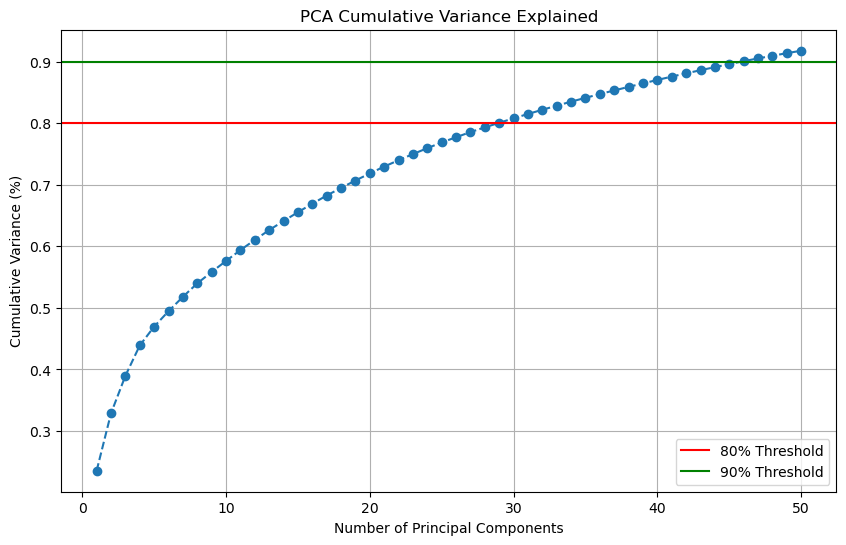

Number of PCs to explain 80% variance: 29
Number of PCs to explain 90% variance: 46

--- PC1 Top Features ---
Cut_FREQ: 0.157 (+)
Putbacks_FREQ: 0.154 (+)
Restricted Area - FREQ: 0.152 (+)
('OVERALL', 'FG_PCT'): 0.151 (+)
('OVERALL', '3 FG_PCT'): 0.151 (+)
('OVERALL', '2 FG_PCT'): 0.151 (+)
PNR_Roll_FREQ: 0.150 (+)
('Touch < 2 Seconds', 'FG_PCT'): 0.147 (+)

--- PC2 Top Features ---
('Touch 2-6 Seconds', '2 FG_PCT'): 0.145 (+)
Spot_Up_FG_PCT: 0.145 (+)
('Touch 2-6 Seconds', 'FG_PCT'): 0.137 (+)
Spot_Up_PPP: 0.136 (+)
DEF_OVERALL_D_FGM: 0.135 (+)
Spot_Up_EFG_PCT: 0.135 (+)
('7+ Dribbles', '2 FG_PCT'): 0.135 (+)
('7+ Dribbles', 'FG_PCT'): 0.134 (+)

--- PC3 Top Features ---
Corner 3 - FREQ: 0.258 (+)
Right Corner 3 - FREQ: 0.244 (+)
TOV_PER_MIN: -0.238 (-)
Left Corner 3 - FREQ: 0.238 (+)
Spot_Up_FREQ: 0.237 (+)
AST_PER_MIN: -0.219 (-)
In The Paint (Non-RA) - FREQ: -0.194 (-)
PFD_PER_MIN: -0.175 (-)


In [279]:

# ---------------------------------------------------------
# 1. Prepare the Feature Matrix (X)
# ---------------------------------------------------------
# Assume your final dataframe is called 'df_model' (or whatever you named it)
# We need to drop metadata and the 'MIN' column (which was only for imputation)
metadata_cols = ['PLAYER_ID', 'PLAYER', 'SEASON', 'MIN', 'GP', 'Team', 'TEAM']
x_cols = [c for c in df_model.columns if c not in metadata_cols]

# Extract the numeric data
X = df_model[x_cols].select_dtypes(include=[np.number])

print(f"Input Features: {X.shape[1]} columns")

# ---------------------------------------------------------
# 2. Standardization (Crucial for PCA)
# ---------------------------------------------------------
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
X_scaled = X.copy()

for group in [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS, PLAYMAKING_COLS]:
    cols = [c for c in group if c in X_scaled.columns]
    X_scaled[cols] = StandardScaler().fit_transform(X_scaled[cols])
scaled_cols = set()

for group in [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS, PLAYMAKING_COLS]:
    cols = [c for c in group if c in X_scaled.columns]
    scaled_cols.update(cols)

# Scale remaining numeric columns (those not in any group)
remaining_cols = [c for c in X_scaled.columns if c not in scaled_cols]

if len(remaining_cols) > 0:
    X_scaled[remaining_cols] = StandardScaler().fit_transform(X_scaled[remaining_cols])

# =========================
# Reduce ball-dominance gravity
# =========================

BALL_DOM_WEIGHT = 0.75  # do not go below 0.5

for c in BALL_DOM_COLS:
    if c in X_scaled.columns:
        X_scaled[c] *= BALL_DOM_WEIGHT

# ---------------------------------------------------------
# 3. Run PCA
# ---------------------------------------------------------
# We start with a high number to see the full curve
pca = PCA(n_components=50) 
X_pca = pca.fit_transform(X_scaled)
X_pca_for_graph = X_pca[:, 1:]  # drop PC1 for similarity only


# ---------------------------------------------------------
# 4. Variance Analysis (The "Scree Plot")
# ---------------------------------------------------------
# Calculate cumulative variance explained
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 51), cum_var, marker='o', linestyle='--')
plt.title('PCA Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance (%)')
plt.axhline(y=0.80, color='r', linestyle='-', label='80% Threshold')
plt.axhline(y=0.90, color='g', linestyle='-', label='90% Threshold')
plt.grid(True)
plt.legend()
plt.savefig('pca_scree_plot.png') # Saves plot to folder
plt.show()

# Find exact number of components for 80% and 90%
n_80 = np.argmax(cum_var >= 0.80) + 1
n_90 = np.argmax(cum_var >= 0.90) + 1

print(f"Number of PCs to explain 80% variance: {n_80}")
print(f"Number of PCs to explain 90% variance: {n_90}")

# ---------------------------------------------------------
# 5. Interpret the Components (What do they mean?)
# ---------------------------------------------------------
# Let's look at the top 3 components to see if the math matches basketball logic
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(50)], 
    index=X.columns
)

def print_top_features(loadings, pc_num):
    print(f"\n--- PC{pc_num} Top Features ---")
    # Sort by absolute value to see what drives this component
    sorted_features = loadings[f'PC{pc_num}'].abs().sort_values(ascending=False)
    for feature, score in sorted_features.head(8).items():
        # Get the actual sign (+ or -)
        sign = loadings.loc[feature, f'PC{pc_num}']
        direction = "(+)" if sign > 0 else "(-)"
        print(f"{feature}: {sign:.3f} {direction}")

print_top_features(loadings, 1)
print_top_features(loadings, 2)
print_top_features(loadings, 3)

### trying micro-clustering to graph network clustering first to see outcomes

In [282]:
# Try to import the specific community library, else fallback
try:
    import community.community_louvain as community_louvain
    HAS_LOUVAIN_LIB = True
except ImportError:
    from networkx.algorithms.community import louvain_communities
    HAS_LOUVAIN_LIB = False

def run_clustering_and_viz(df_model, n_components=29):
    """
    Runs the full PCA -> Micro-Cluster -> Network -> Archetype pipeline.
    Generates 3 visualizations to explain the process.
    """
    print(f"--- Starting Clustering Pipeline (N={n_components}) ---")
    
    # ---------------------------------------------------------
    # 1. Prepare Data
    # ---------------------------------------------------------
    # Drop non-numeric for math (Keep IDs separate)
    # Ensure 'df_model' has your 170 columns + 'PLAYER_ID'/'SEASON'
    meta_cols = ['PLAYER_ID', 'PLAYER', 'SEASON', 'Team', 'MIN']
    X = df_model.drop(columns=[c for c in meta_cols if c in df_model.columns], errors='ignore')
    X = X.select_dtypes(include=[np.number]).fillna(0)
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # ---------------------------------------------------------
    # 2. PCA (The Map)
    # ---------------------------------------------------------
    # Full PCA for Logic
    pca_full = PCA(n_components=n_components)
    X_pca_logic = pca_full.fit_transform(X_scaled)
    
    # 2D PCA for Visualization ONLY
    pca_2d = PCA(n_components=2)
    X_pca_viz = pca_2d.fit_transform(X_scaled)
    
    # VIZ 1: The Raw Player Map
    plt.figure(figsize=(12, 10))
    plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], alpha=0.3, s=15, c='lightgrey', label='Players')
    plt.title('Stage 1: The NBA Player Map (PCA Reduced)', fontsize=16)
    plt.xlabel('Principal Component 1 (Usually Usage/Volume)')
    plt.ylabel('Principal Component 2 (Usually Size/Defense)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('stage1_player_map.png')
    plt.show()
    plt.close()
    print(" > Generated 'stage1_player_map.png'")

    # ---------------------------------------------------------
    # 3. Micro-Clustering (The Nodes)
    # ---------------------------------------------------------
    # Create 60 small neighborhoods
    n_micro = 300
    kmeans = KMeans(n_clusters=n_micro, random_state=42, n_init=10)
    micro_labels = kmeans.fit_predict(X_pca_logic)
    micro_centers_logic = kmeans.cluster_centers_
    
    # For Viz: Find center of each micro-cluster in 2D space
    micro_centers_viz = []
    for i in range(n_micro):
        mask = (micro_labels == i)
        if mask.sum() > 0:
            micro_centers_viz.append(X_pca_viz[mask].mean(axis=0))
        else:
            micro_centers_viz.append([0, 0])
    micro_centers_viz = np.array(micro_centers_viz)

    # VIZ 2: The Micro-Clusters
    plt.figure(figsize=(12, 10))
    plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], alpha=0.1, s=10, c='lightgrey')
    plt.scatter(micro_centers_viz[:, 0], micro_centers_viz[:, 1], s=150, c='red', edgecolors='k', label='Micro-Clusters')
    plt.title(f'Stage 2: Micro-Clustering (K={n_micro})', fontsize=16)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('stage2_micro_clusters.png')
    plt.show()
    plt.close()
    print(" > Generated 'stage2_micro_clusters.png'")

    # ---------------------------------------------------------
    # 4. Network Graph (The Connections)
    # ---------------------------------------------------------
    # Build graph from logical centers (33D space)
    A = kneighbors_graph(micro_centers_logic, n_neighbors=4, mode='distance', include_self=False)
    G = nx.from_scipy_sparse_array(A)
    
    # Weight edges by similarity
    for u, v, data in G.edges(data=True):
        G[u][v]['weight'] = 1.0 / (1.0 + data['weight'])

    # ---------------------------------------------------------
    # 5. Community Detection (The Archetypes)
    # ---------------------------------------------------------
    if HAS_LOUVAIN_LIB:
        partition = community_louvain.best_partition(G, weight='weight', random_state=42)
    else:
        # Fallback to NetworkX
        communities = louvain_communities(G, weight='weight', seed=42)
        partition = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                partition[node] = idx

    num_archetypes = len(set(partition.values()))
    
    # VIZ 3: The Final Network
    plt.figure(figsize=(12, 10))
    # Use the 2D positions for the nodes
    pos = dict(enumerate(micro_centers_viz))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='blue')
    
    # Draw nodes colored by Archetype
    colors = [partition[i] for i in range(len(G.nodes))]
    nx.draw_networkx_nodes(G, pos, node_size=200, node_color=colors, cmap=plt.cm.tab20, edgecolors='k')
    
    plt.title(f'Stage 3: Network Community Detection\nFound {num_archetypes} Natural Archetypes', fontsize=16)
    plt.axis('off')
    plt.savefig('stage3_final_network.png')
    plt.show()
    plt.close()
    print(" > Generated 'stage3_final_network.png'")

    # ---------------------------------------------------------
    # 6. Map Results to Dataframe
    # ---------------------------------------------------------
    df_out = df_model.copy()
    df_out['Micro_Cluster'] = micro_labels
    df_out['Archetype_ID'] = df_out['Micro_Cluster'].map(partition)
    
    print("-" * 30)
    print(f"SUCCESS: Found {num_archetypes} Archetypes.")
    print(df_out['Archetype_ID'].value_counts().sort_index())
    
    return df_out

# USAGE:
# final_df = run_clustering_and_viz(df_model, n_components=33)

--- Starting Clustering Pipeline (N=30) ---


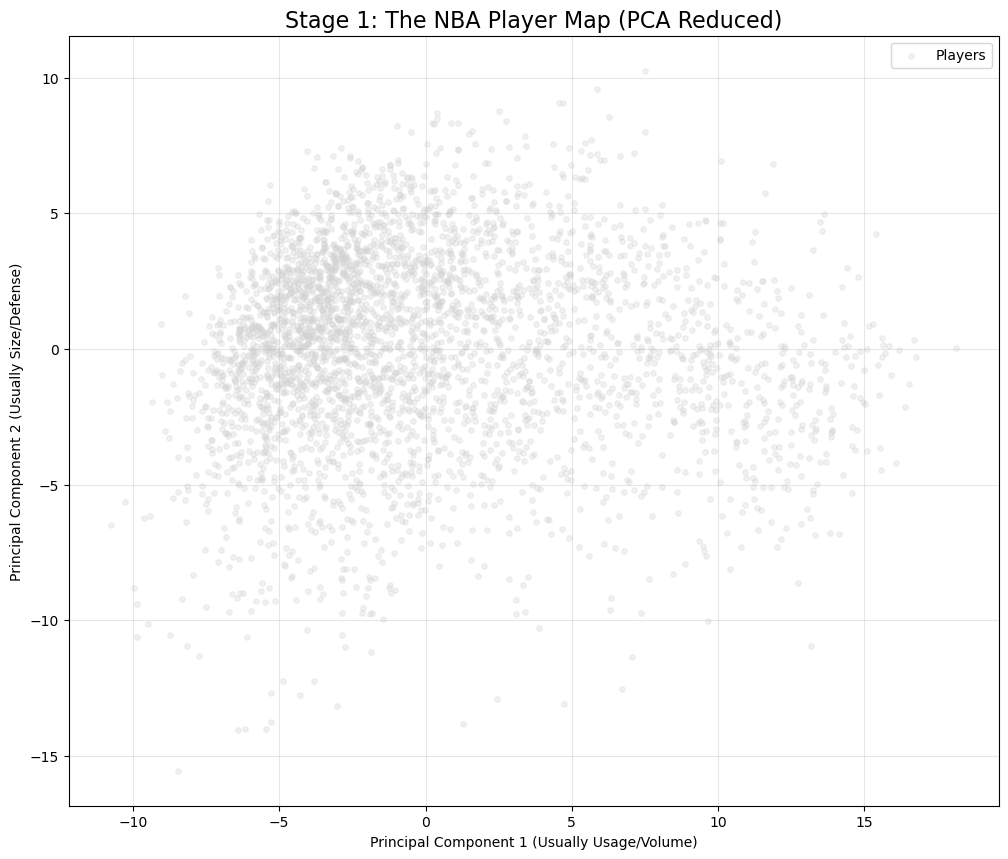

 > Generated 'stage1_player_map.png'


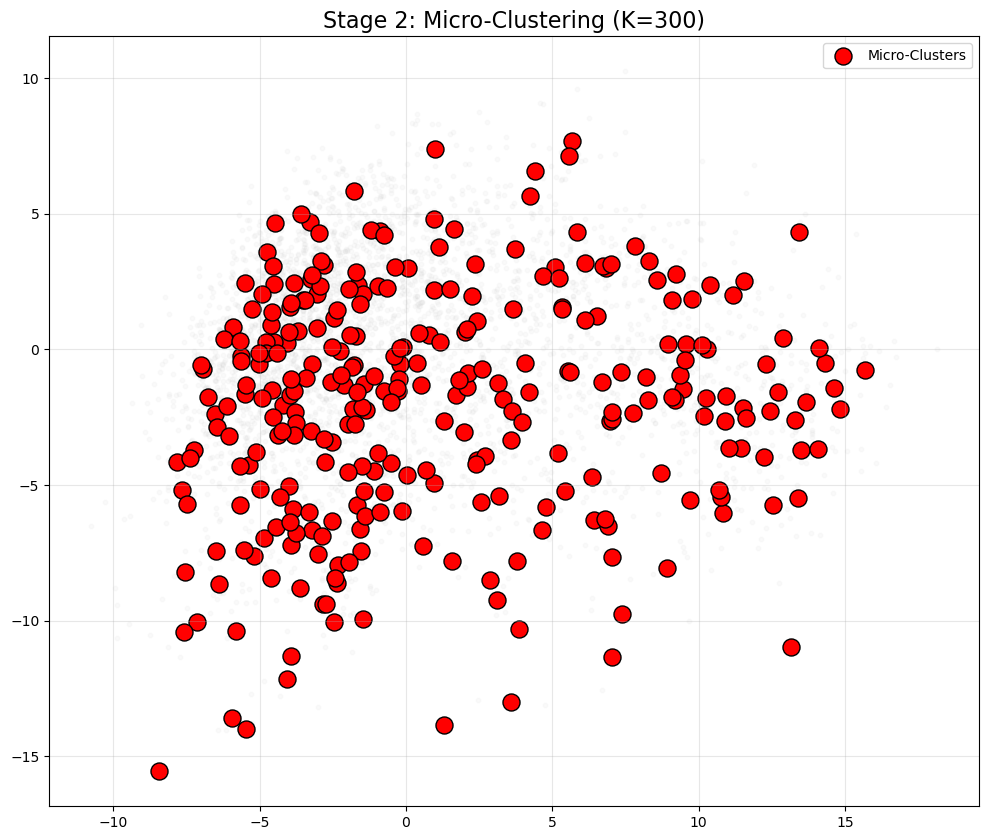

 > Generated 'stage2_micro_clusters.png'


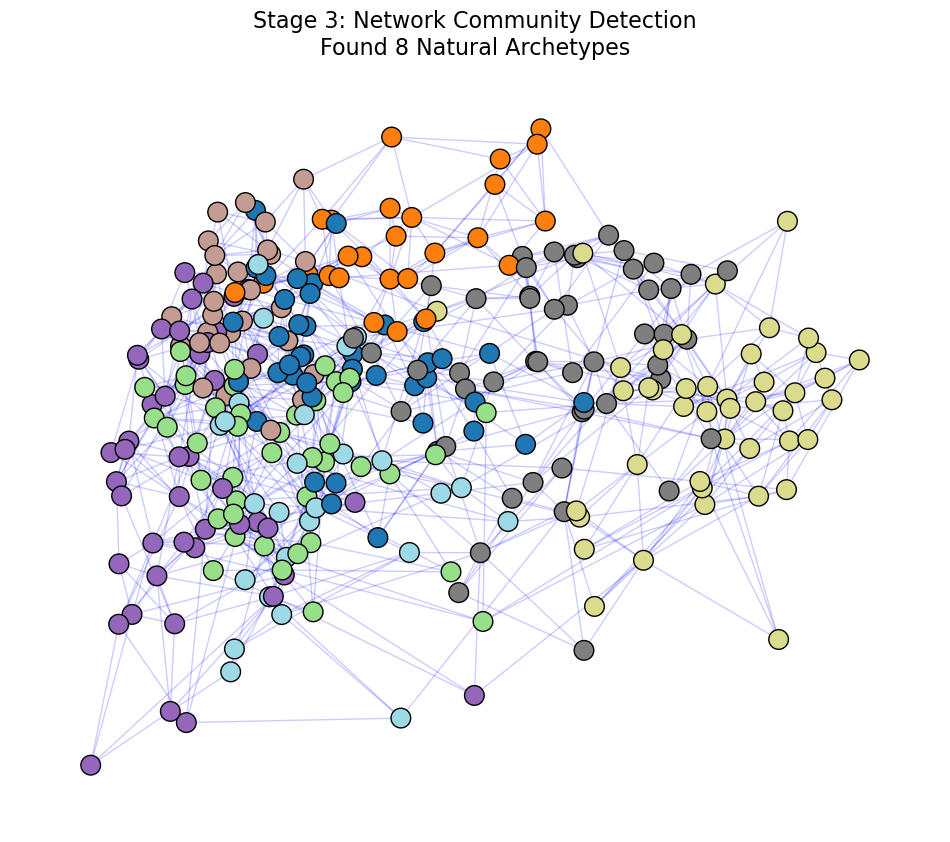

 > Generated 'stage3_final_network.png'
------------------------------
SUCCESS: Found 8 Archetypes.
Archetype_ID
0    652
1    592
2    306
3    436
4    714
5    489
6    322
7    110
Name: count, dtype: int64


In [283]:
final_df = run_clustering_and_viz(df_model, n_components=30)

### trying to see if the method of a network graph clustering for all the players not by micro clusters will give us good results

In [293]:
def run_direct_player_network(df_model, n_components=29):
    """
    Builds a graph where Every Player is a Node.
    Automatically tunes resolution to find 8-15 Archetypes.
    """
    print(f"--- Starting Direct Player Network Clustering (N={n_components}) ---")
    
    # 1. Prepare Data
    meta_cols = ['PLAYER_ID', 'PLAYER', 'SEASON', 'Position', 'Team', 'MIN']
    X = df_model.drop(columns=[c for c in meta_cols if c in df_model.columns], errors='ignore')
    X = X.select_dtypes(include=[np.number]).fillna(0)
    
    # Standardize & PCA
    scaler = StandardScaler()
    # -------------------------
    # GROUP-WISE SCALING (CRITICAL FOR GUARDS)
    # -------------------------
    X_scaled = X.copy()

    SHOT_FREQ_COLS = [c for c in X.columns if c.endswith('_FREQ')]
    SHOT_EFF_COLS  = [c for c in X.columns if c.endswith('_FG_PCT') or c.endswith('_EFG_PCT') or c.endswith('_PPP')]

    BALL_DOM_COLS = [
        'PNR_Handler_FREQ','PNR_Handler_PPP','PNR_Handler_FG_PCT','PNR_Handler_EFG_PCT',
        'Isolation_FREQ','Isolation_PPP','Isolation_FG_PCT','Isolation_EFG_PCT',
        "('Pull Ups', 'FG_PCT')",
        "('Touch 6+ Seconds', 'FG_PCT')"
    ]

    OFF_BALL_COLS = [
        'Spot_Up_FREQ','Cut_FREQ','Putbacks_FREQ',
        "('Catch and Shoot', 'FG_PCT')",
        "('Touch < 2 Seconds', 'FG_PCT')"
    ]

    PLAYMAKING_COLS = ['AST_PER_MIN','AST_TOV_RATIO']
    
    PHYSICAL_COLS = [
        'Height_Inches','Weight','POS_Guard','POS_Forward','POS_Center'
    ]
    

    for group in [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS, PLAYMAKING_COLS, PHYSICAL_COLS]:
        cols = [c for c in group if c in X_scaled.columns]
        if len(cols) > 0:
            X_scaled[cols] = StandardScaler().fit_transform(X_scaled[cols])
    scaled_cols = set()
    for group in [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS, PLAYMAKING_COLS, PHYSICAL_COLS]:
        cols = [c for c in group if c in X_scaled.columns]
        scaled_cols.update(cols)
    remaining_cols = [c for c in X_scaled.columns if c not in scaled_cols]
    if len(remaining_cols) > 0:
        X_scaled[remaining_cols] = StandardScaler().fit_transform(X_scaled[remaining_cols])

    # -------------------------
    # Reduce ball-dominance gravity
    # -------------------------
    BALL_DOM_WEIGHT = 0.8

    for c in BALL_DOM_COLS:
        if c in X_scaled.columns:
            X_scaled[c] *= BALL_DOM_WEIGHT
    # -------------------------
    
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Viz Helper (2D)
    pca_2d = PCA(n_components=2)
    X_viz = pca_2d.fit_transform(X_scaled)
    
    # 2. Build KNN Graph (The Web)
    # n_neighbors=15 is a sweet spot for 3000-5000 nodes. 
    # It ensures players are connected to their "squad" but not the whole league.
    print(f" > Building Graph on {len(X)} players...")
    A = kneighbors_graph(X_pca[:, 1:], n_neighbors=15, mode='distance', include_self=False)
    G = nx.from_scipy_sparse_array(A)
    
    # Weight edges (Similarity)
    for u, v, data in G.edges(data=True):
        G[u][v]['weight'] = 1.0 / (1.0 + data['weight'])
        
    # 3. Resolution Tuning Loop (The "Fix")
    target_range = (12, 16)
    found_partition = None
    final_res = 1.0
    
    # We test values from low (big clusters) to high (granular clusters)
    # 0.8 usually works well for NBA data to separate "Stars" from "Role Players"
    test_resolutions = [0.6, 0.9, 1.0, 1.1, 1.2, 1.4]
    
    for res in test_resolutions:
        communities = louvain_communities(G, weight='weight', resolution=res, seed=42)
        count = len(communities)
        print(f"   [Resolution {res}] -> Found {count} clusters.")
        
        if target_range[0] <= count <= target_range[1]:
            # Success!
            final_res = res
            found_partition = {}
            for idx, comm in enumerate(communities):
                for node in comm:
                    found_partition[node] = idx
            break
            
    # Fallback if loop finishes without hitting target (just take the last one)
    if found_partition is None:
        print("   Warning: Target range not hit. Using last result.")
        found_partition = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                found_partition[node] = idx

    num_archetypes = len(set(found_partition.values()))
    
    # 4. Visualization
    plt.figure(figsize=(12, 10))
    colors = [found_partition[i] for i in range(len(X_viz))]
    scatter = plt.scatter(X_viz[:, 0], X_viz[:, 1], c=colors, cmap='tab20', s=15, alpha=0.6)
    
    plt.title(f'Direct Player Network (Res={final_res})\nFound {num_archetypes} Natural Archetypes', fontsize=16)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.colorbar(scatter, label='Archetype ID')
    plt.savefig('stage3_direct_network.png')
    plt.show()
    plt.close()
    
    # 5. Save to DF
    df_out = df_model.copy()
    df_out['Archetype_ID'] = df_out.index.map(found_partition)
    
    print("-" * 30)
    print(f"SUCCESS: Created {num_archetypes} Archetypes.")
    print(df_out['Archetype_ID'].value_counts().sort_index())
    
    return df_out

# USAGE:
# final_df = run_direct_player_network(df_model, n_components=33)

--- Starting Direct Player Network Clustering (N=30) ---
 > Building Graph on 3621 players...
   [Resolution 0.6] -> Found 7 clusters.
   [Resolution 0.9] -> Found 9 clusters.
   [Resolution 1.0] -> Found 11 clusters.
   [Resolution 1.1] -> Found 12 clusters.


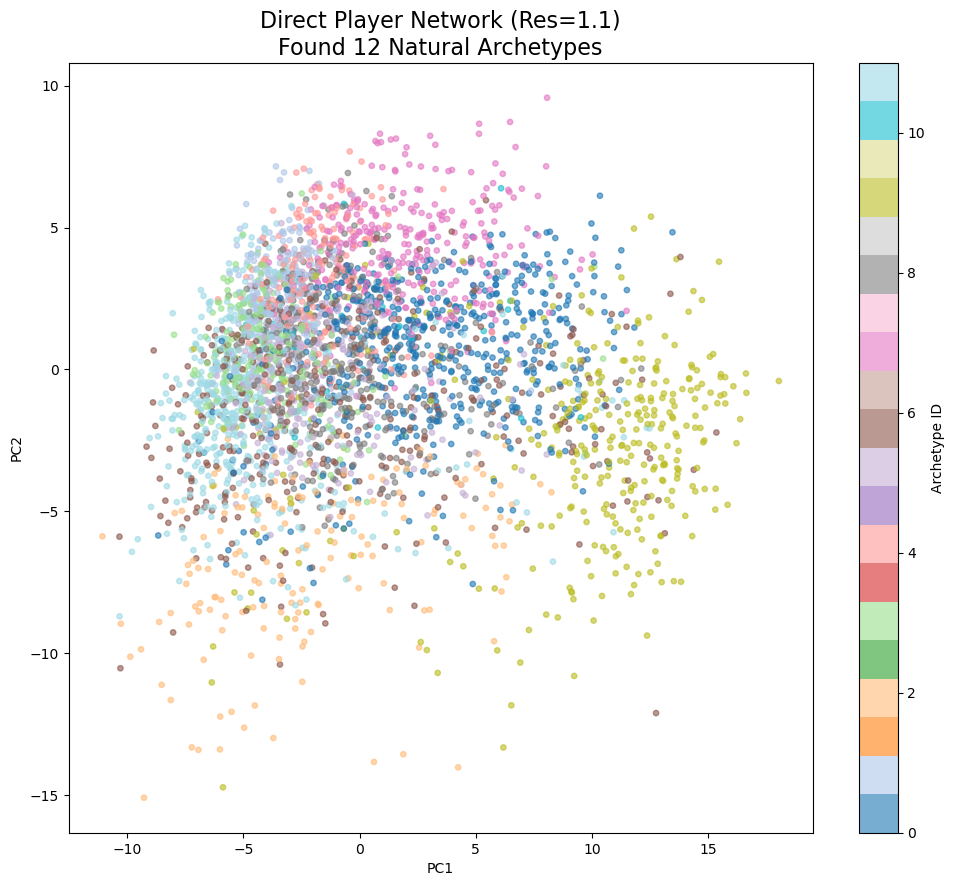

------------------------------
SUCCESS: Created 12 Archetypes.
Archetype_ID
0.0     546
1.0     229
2.0     162
3.0     227
4.0     191
5.0     312
6.0     370
7.0     311
8.0     377
9.0     351
10.0     32
11.0    510
Name: count, dtype: int64


In [294]:
final_df = run_direct_player_network(df_model, n_components=30)

### we will go with the micro clustering method with 300 micro clusters

In [321]:
def run_clustering_with_viz_and_tuning(df_model, n_components=29, n_micro=240):
    """
    1. PCA (33 dims for logic, 2 dims for viz)
    2. Micro-Clustering (240 nodes)
    3. Network Graph Construction
    4. Auto-Tuning Resolution (to find 8-15 Archetypes)
    5. Visualization of all stages
    """
    print(f"--- Starting Clustering Pipeline (Rows: {len(df_model)}) ---")
    
    # ---------------------------------------------------------
    # 1. PREPARE DATA
    # ---------------------------------------------------------
    meta_cols = ['PLAYER_ID', 'PLAYER', 'SEASON', 'Position', 'Team', 'MIN', 'Archetype_ID', 'Micro_Cluster']
    X = df_model.drop(columns=[c for c in meta_cols if c in df_model.columns], errors='ignore')
    X = X.select_dtypes(include=[np.number]).fillna(0)
    
    # Scale
    scaler = StandardScaler()
    # -------------------------
    # GROUP-WISE SCALING (CRITICAL FOR GUARDS)
    # -------------------------
    X_scaled = X.copy()

    SHOT_FREQ_COLS = [c for c in X.columns if c.endswith('_FREQ')]
    SHOT_EFF_COLS  = [c for c in X.columns if c.endswith('_FG_PCT') or c.endswith('_EFG_PCT') or c.endswith('_PPP')]

    BALL_DOM_COLS = [
        'PNR_Handler_FREQ','PNR_Handler_PPP','PNR_Handler_FG_PCT','PNR_Handler_EFG_PCT',
        'Isolation_FREQ','Isolation_PPP','Isolation_FG_PCT','Isolation_EFG_PCT',
        "('Pull Ups', 'FG_PCT')",
        "('Touch 6+ Seconds', 'FG_PCT')"
    ]

    OFF_BALL_COLS = [
        'Spot_Up_FREQ','Cut_FREQ','Putbacks_FREQ',
        "('Catch and Shoot', 'FG_PCT')",
        "('Touch < 2 Seconds', 'FG_PCT')"
    ]

    PLAYMAKING_COLS = ['AST_PER_MIN','AST_TOV_RATIO']
    
    PHYSICAL_COLS = [
        'Height_Inches','Weight','POS_Guard','POS_Forward','POS_Center'
    ]
    

    for group in [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS, PLAYMAKING_COLS, PHYSICAL_COLS]:
        cols = [c for c in group if c in X_scaled.columns]
        if len(cols) > 0:
            X_scaled[cols] = StandardScaler().fit_transform(X_scaled[cols])
    scaled_cols = set()
    for group in [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS, PLAYMAKING_COLS, PHYSICAL_COLS]:
        cols = [c for c in group if c in X_scaled.columns]
        scaled_cols.update(cols)
    remaining_cols = [c for c in X_scaled.columns if c not in scaled_cols]
    if len(remaining_cols) > 0:
        X_scaled[remaining_cols] = StandardScaler().fit_transform(X_scaled[remaining_cols])

    # -------------------------
    # Reduce ball-dominance gravity
    # -------------------------
    BALL_DOM_WEIGHT = 0.65

    for c in BALL_DOM_COLS:
        if c in X_scaled.columns:
            X_scaled[c] *= BALL_DOM_WEIGHT
    
    # REB_WEIGHT = 0.9  # try 0.4–0.6

    # for c in X_scaled.columns:
    #     if 'REB_' in c:
    #         X_scaled[c] *= REB_WEIGHT

    # ---------------------------------------------------------
    # PCA Logic (33D)
    pca_full = PCA(n_components=n_components)
    X_pca_logic = pca_full.fit_transform(X_scaled)
    
    # PCA Viz (2D)
    pca_2d = PCA(n_components=2)
    X_pca_viz = pca_2d.fit_transform(X_scaled)

    # VIZ 1: Player Map
    plt.figure(figsize=(12, 10))
    plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], alpha=0.3, s=15, c='lightgrey', label='Players')
    plt.title('Stage 1: The Player Map (PCA 2D Projection)', fontsize=16)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.savefig('stage1_player_map.png')
    plt.show()
    plt.close()
    print(" > Saved 'stage1_player_map.png'")

    # ---------------------------------------------------------
    # 2. MICRO-CLUSTERING
    # ---------------------------------------------------------
    print(f" > Creating {n_micro} Micro-Clusters...")
    kmeans = KMeans(n_clusters=n_micro, random_state=42, n_init=10)
    micro_labels = kmeans.fit_predict(X_pca_logic)
    micro_centers = kmeans.cluster_centers_
    
    # Calculate 2D centers for Viz
    micro_centers_viz = []
    for i in range(n_micro):
        mask = (micro_labels == i)
        if mask.sum() > 0:
            micro_centers_viz.append(X_pca_viz[mask].mean(axis=0))
        else:
            micro_centers_viz.append([0, 0])
    micro_centers_viz = np.array(micro_centers_viz)

    # VIZ 2: Micro-Clusters
    plt.figure(figsize=(12, 10))
    plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], alpha=0.05, s=10, c='lightgrey')
    plt.scatter(micro_centers_viz[:, 0], micro_centers_viz[:, 1], s=80, c='red', edgecolors='k', label='Micro-Clusters')
    plt.title(f'Stage 2: Micro-Clustering ({n_micro} Groups)', fontsize=16)
    plt.legend()
    plt.savefig('stage2_micro_clusters.png')
    plt.show()
    plt.close()
    print(" > Saved 'stage2_micro_clusters.png'")

    # ---------------------------------------------------------
    # 3. NETWORK GRAPH
    # ---------------------------------------------------------
    # Connect each micro-cluster to its 5 nearest neighbors
    A = kneighbors_graph(
        #micro_centers[:, 1:],   # DROP PC1 HERE
        micro_centers,
        n_neighbors=4,
        mode='distance',
        include_self=False
    )

    G = nx.from_scipy_sparse_array(A)
    
    # Weight edges
    for u, v, data in G.edges(data=True):
        G[u][v]['weight'] = 1.0 / (1.0 + data['weight'])

    # ---------------------------------------------------------
    # 4. RESOLUTION TUNING (The Fix)
    # ---------------------------------------------------------
    target_range = (12, 15)
    found_partition = None
    final_res = 1.0
    
    # Test resolutions to force the graph into the right number of chunks
    resolutions = [0.8, 0.9, 1.0, 1.1, 1.2, 1.4, 1.6]
    print(f" > Tuning Resolution (Target: {target_range} clusters)...")
    
    for res in resolutions:
        communities = louvain_communities(G, weight='weight', resolution=res, seed=42)
        count = len(communities)
        print(f"   [Res {res}] -> Found {count} clusters.")
        
        if target_range[0] <= count <= target_range[1]:
            final_res = res
            found_partition = {}
            for idx, comm in enumerate(communities):
                for node in comm:
                    found_partition[node] = idx
            break
            
    if found_partition is None:
        print("   Warning: Target range not perfectly hit. Using last result.")
        found_partition = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                found_partition[node] = idx

    num_archetypes = len(set(found_partition.values()))
    
    # VIZ 3: Final Network
    plt.figure(figsize=(12, 10))
    pos = dict(enumerate(micro_centers_viz))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.15, edge_color='blue')
    # Draw nodes
    colors = [found_partition[i] for i in range(len(G.nodes))]
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color=colors, cmap=plt.cm.tab20, edgecolors='k')
    
    plt.title(f'Stage 3: Network Graph & Archetypes\nFound {num_archetypes} Clusters (Res={final_res})', fontsize=16)
    plt.axis('off')
    plt.savefig('stage3_final_network.png')
    plt.show()
    plt.close()
    print(" > Saved 'stage3_final_network.png'")

    # ---------------------------------------------------------
    # 5. ASSIGN RESULTS
    # ---------------------------------------------------------
    df_out = df_model.copy()
    df_out['Micro_Cluster'] = micro_labels
    df_out['Archetype_ID'] = df_out['Micro_Cluster'].map(found_partition)
    
    print("-" * 40)
    print(f"SUCCESS: Found {num_archetypes} Natural Archetypes.")
    print("-" * 40)
    
    return df_out, G, found_partition

# USAGE:
# final_df, graph_network, cluster_map = run_clustering_with_viz_and_tuning(df_model, n_micro=240)

--- Starting Clustering Pipeline (Rows: 3621) ---


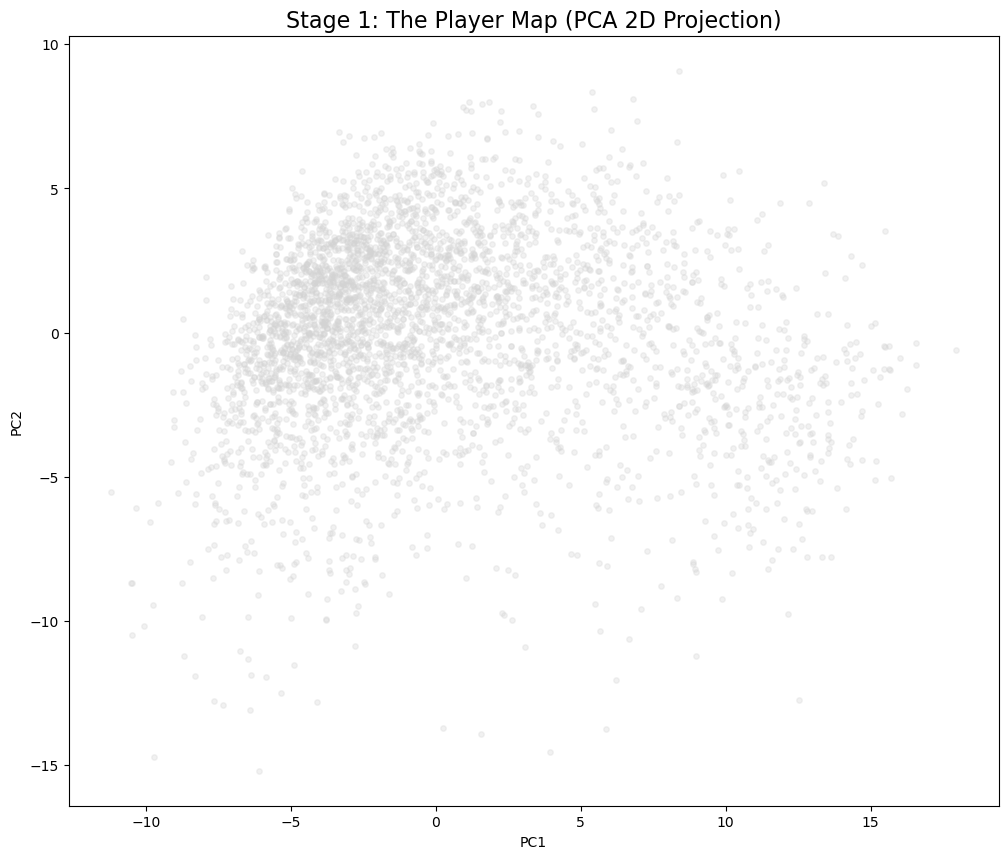

 > Saved 'stage1_player_map.png'
 > Creating 300 Micro-Clusters...


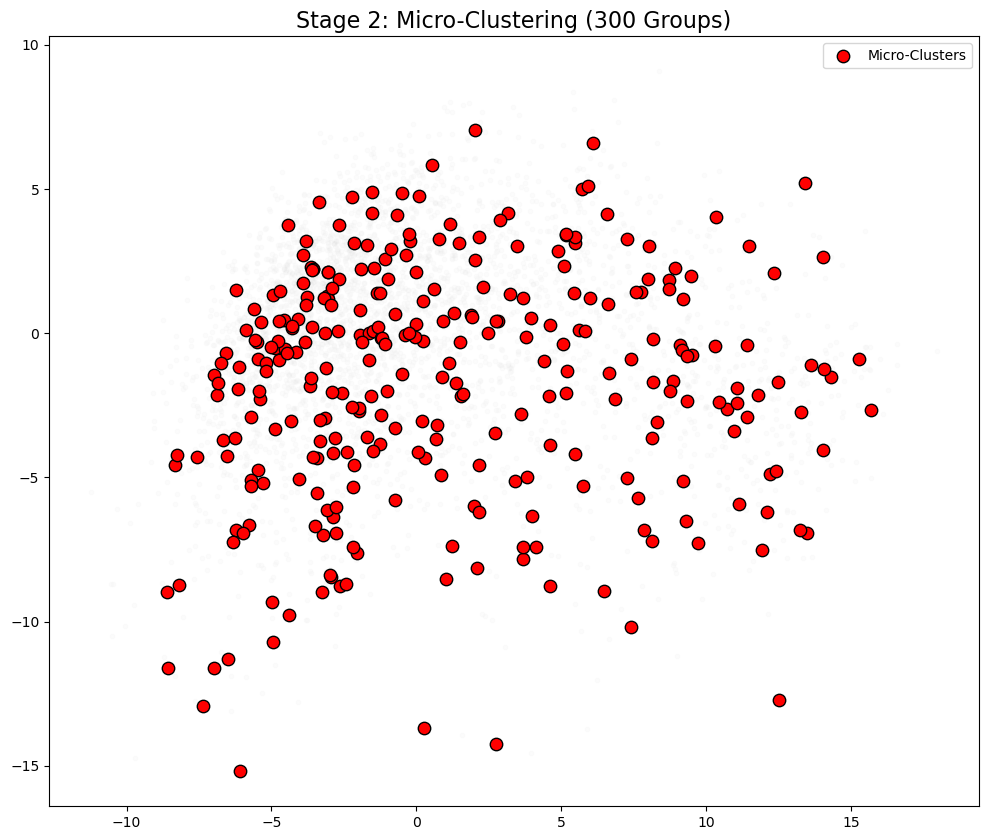

 > Saved 'stage2_micro_clusters.png'
 > Tuning Resolution (Target: (12, 15) clusters)...
   [Res 0.8] -> Found 7 clusters.
   [Res 0.9] -> Found 9 clusters.
   [Res 1.0] -> Found 10 clusters.
   [Res 1.1] -> Found 11 clusters.
   [Res 1.2] -> Found 12 clusters.


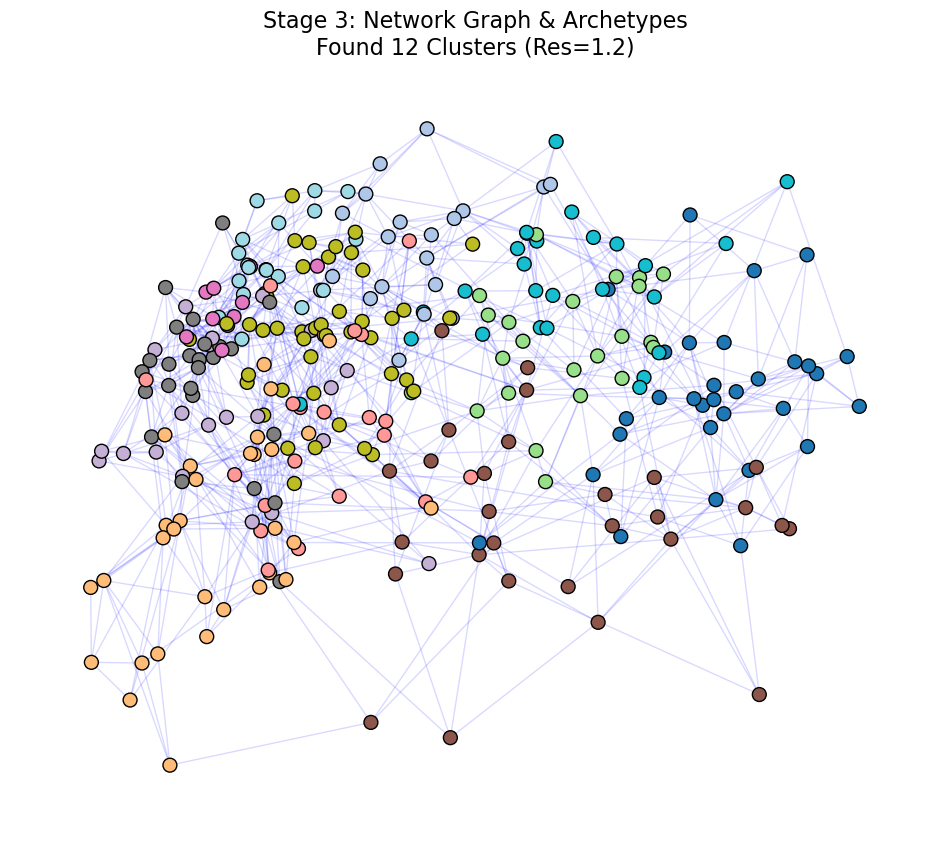

 > Saved 'stage3_final_network.png'
----------------------------------------
SUCCESS: Found 12 Natural Archetypes.
----------------------------------------


In [322]:
final_df, graph_network, cluster_map = run_clustering_with_viz_and_tuning(df_model,n_components=30, n_micro=300)

In [323]:
new_cols = ['PLAYER', 'SEASON']

final_df_merged = final_df.merge(
    df_cleaned[['PLAYER_ID', 'MIN', *new_cols]],
    on=['PLAYER_ID', 'MIN'],
    how='left'
)

cols = final_df_merged.columns.tolist()

player_idx = cols.index('PLAYER_ID')

reordered_cols = (
    cols[:player_idx + 1] +
    new_cols +
    [c for c in cols[player_idx + 1:] if c not in new_cols]
)

final_df_merged = final_df_merged[reordered_cols]

In [327]:
def advanced_cluster_profiling(df, cluster_col='Archetype_ID', n_traits=15):
    """
    Generates a 'Deep Dive' report for each cluster to help with naming.
    - TRAITS: Shows features that are most statistically distinct (Z-Score).
    - PLAYERS: Shows 'Archetype Definers' (Closest to center) and 'Stars' (High Minutes).
    """
    print(f"--- STARTING ADVANCED PROFILING ({len(df)} Players) ---")
    
    # 1. Setup Data
    # Identify numeric columns for stats
    meta_cols = ['PLAYER_ID', 'PLAYER', 'SEASON', 'Position', 'Team', 'MIN', 
                 'Archetype_ID', 'Micro_Cluster', 'Draft Year']
    numeric_df = df.select_dtypes(include=[np.number])
    # Drop ID columns from calculation
    stat_cols = [c for c in numeric_df.columns if c not in meta_cols]
    
    # Calculate Global Mean and Std for Z-Score
    global_mean = df[stat_cols].mean()
    global_std = df[stat_cols].std()
    
    # 2. Iterate through Clusters
    # Sort by size (largest clusters first)
    cluster_counts = df[cluster_col].value_counts().sort_values(ascending=False)
    
    for arch_id in cluster_counts.index:
        members = df[df[cluster_col] == arch_id]
        count = len(members)
        
        print("\n" + "="*80)
        print(f">>> CLUSTER {arch_id}  (Count: {count} players)")
        print("="*80)
        
        # --- A. TOP DISTINCTIVE TRAITS ---
        # Calculate cluster mean
        cluster_mean = members[stat_cols].mean()
        
        # Calculate Z-Score: (ClusterMean - GlobalMean) / GlobalStd
        z_scores = (cluster_mean - global_mean) / global_std
        
        # Sort by absolute distinctiveness (High positive OR High negative)
        sorted_traits = z_scores.abs().sort_values(ascending=False).head(n_traits)
        
        print(f"\n[Top {n_traits} Distinguishing Features]")
        print(f"{'Feature':<40} | {'Value':<10} | {'Deviation (Z-Score)':<20}")
        print("-" * 80)
        
        for feature in sorted_traits.index:
            z_val = z_scores[feature]
            actual_val = cluster_mean[feature]
            
            # Interpret the Z-Score
            if z_val > 1.0: impact = "HIGH (++ )"
            elif z_val > 0.5: impact = "High (+   )"
            elif z_val < -1.0: impact = "LOW  (-- )"
            elif z_val < -0.5: impact = "Low  (-   )"
            else: impact = "Avg"
            
            print(f"{feature:<40} | {actual_val:<10.2f} | {z_val:>6.2f} STD  {impact}")

        # --- B. REPRESENTATIVE PLAYERS ---
        # 1. "The Core" (Mathematically closest to the average of this cluster)
        # We calculate Euclidean distance of every member to the cluster_mean
        member_stats = members[stat_cols].fillna(0)
        
        # Calculate distance to the cluster centroid
        # (We use Scaled stats for fair distance)
        scaler = StandardScaler()
        scaled_stats = scaler.fit_transform(member_stats)
        centroid = scaled_stats.mean(axis=0)
        
        dists = np.linalg.norm(scaled_stats - centroid, axis=1)
        members['dist_to_center'] = dists
        
        # Select Top 10 Closest (The "Purest" examples)
        core_players = members.sort_values('dist_to_center').head(15)
        
        # Select Top 10 by Minutes (The "Stars" everyone knows)
        if 'MIN' in members.columns:
            star_players = members.sort_values('MIN', ascending=False).head(15)
        else:
            star_players = members.head(10) # Fallback
            
        print(f"\n[Representative Players]")
        
        print(f"TYPE 1: THE ARCHETYPE DEFINERS (Mathematically closest to cluster center)")
        print(", ".join([f"{r.PLAYER} ('{str(r.SEASON)[-2:]})" for i, r in core_players.iterrows()]))
        
        print(f"\nTYPE 2: THE STARS (Highest Minutes in this cluster)")
        print(", ".join([f"{r.PLAYER} ('{str(r.SEASON)[-2:]})" for i, r in star_players.iterrows()]))
        
        print("\n")

# USAGE:
# advanced_cluster_profiling(df_final)

In [328]:
advanced_cluster_profiling(final_df_merged, n_traits=20)

--- STARTING ADVANCED PROFILING (3621 Players) ---

>>> CLUSTER 9  (Count: 770 players)

[Top 20 Distinguishing Features]
Feature                                  | Value      | Deviation (Z-Score) 
--------------------------------------------------------------------------------
Corner 3 - FREQ                          | 0.14       |   0.79 STD  High (+   )
Left Corner 3 - FREQ                     | 0.07       |   0.74 STD  High (+   )
Right Corner 3 - FREQ                    | 0.07       |   0.73 STD  High (+   )
Spot_Up_FREQ                             | 0.34       |   0.73 STD  High (+   )
Transition_FREQ                          | 0.20       |   0.68 STD  High (+   )
Post_Up_PPP                              | 0.05       |  -0.67 STD  Low  (-   )
Post_Up_FG_PCT                           | 0.03       |  -0.67 STD  Low  (-   )
Post_Up_EFG_PCT                          | 0.03       |  -0.67 STD  Low  (-   )
Post_Up_TOV_FREQ                         | 0.01       |  -0.56 STD  Low  (-   )


C:\Users\yuval\AppData\Local\Temp\ipykernel_17716\2390736243.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  members['dist_to_center'] = dists
C:\Users\yuval\AppData\Local\Temp\ipykernel_17716\2390736243.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  members['dist_to_center'] = dists
C:\Users\yuval\AppData\Local\Temp\ipykernel_17716\2390736243.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [341]:
final_df_merged.to_csv(data_path + "first_final_player_archetypes_2.csv", index=False)

In [76]:
print(df_model.columns.tolist())

['Unnamed: 0', 'PLAYER_ID', 'Weight', 'GP', 'MIN', 'Restricted Area - FG_PCT', 'In The Paint (Non-RA) - FG_PCT', 'Mid-Range - FG_PCT', 'Left Corner 3 - FG_PCT', 'Right Corner 3 - FG_PCT', 'Above the Break 3 - FG_PCT', 'Corner 3 - FG_PCT', 'Restricted Area - FREQ', 'In The Paint (Non-RA) - FREQ', 'Mid-Range - FREQ', 'Left Corner 3 - FREQ', 'Right Corner 3 - FREQ', 'Above the Break 3 - FREQ', 'Corner 3 - FREQ', "('0 Dribbles', '2 FG_PCT')", "('0 Dribbles', '3 FG_PCT')", "('0 Dribbles', 'FG_PCT')", "('0-2 Feet - Very Tight', '2 FG_PCT')", "('0-2 Feet - Very Tight', '3 FG_PCT')", "('0-2 Feet - Very Tight', 'FG_PCT')", "('1 Dribble', '2 FG_PCT')", "('1 Dribble', '3 FG_PCT')", "('1 Dribble', 'FG_PCT')", "('2 Dribbles', '2 FG_PCT')", "('2 Dribbles', '3 FG_PCT')", "('2 Dribbles', 'FG_PCT')", "('2-4 Feet - Tight', '2 FG_PCT')", "('2-4 Feet - Tight', '3 FG_PCT')", "('2-4 Feet - Tight', 'FG_PCT')", "('3-6 Dribbles', '2 FG_PCT')", "('3-6 Dribbles', '3 FG_PCT')", "('3-6 Dribbles', 'FG_PCT')", "('4-

#### visualizing in 3D

In [107]:
def visualize_clusters_3d(df_final, n_components=33):
    """
    Generates an interactive 3D scatter plot using Plotly.
    X=PC1, Y=PC2, Z=PC3
    """
    print("Generating 3D Interactive Plot...")
    
    # 1. Re-run PCA just to get the top 3 specific coordinates for the plot
    # (We do this on the numeric data)
    meta_cols = ['PLAYER_ID', 'PLAYER', 'SEASON', 'Position', 'Team', 'MIN', 
                 'Archetype_ID', 'Micro_Cluster']
    
    # Filter numeric data
    X = df_final.drop(columns=[c for c in meta_cols if c in df_final.columns], errors='ignore')
    X = X.select_dtypes(include=[np.number]).fillna(0)
    
    # Scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Get top 3 PCs
    pca_3d = PCA(n_components=3)
    components = pca_3d.fit_transform(X_scaled)
    
    # 2. Add PC coordinates back to dataframe for plotting
    df_plot = df_final.copy()
    df_plot['PC1'] = components[:, 0]
    df_plot['PC2'] = components[:, 1]
    df_plot['PC3'] = components[:, 2]
    
    # Make sure Archetype_ID is a string so it treats it as a category (discrete color), not a number
    df_plot['Archetype_ID'] = df_plot['Archetype_ID'].astype(str)

    # 3. Create the Plot
    fig = px.scatter_3d(
        df_plot, 
        x='PC1', 
        y='PC2', 
        z='PC3',
        color='Archetype_ID',
        hover_name='PLAYER',
        hover_data=['SEASON', 'Archetype_ID'],
        opacity=0.7,
        size_max=5,
        title='NBA Player Archetypes (3D PCA Space)',
        labels={
            'PC1': 'PC1 (Volume/Usage)', 
            'PC2': 'PC2 (Size/Defense)', 
            'PC3': 'PC3 (Skill/Shooting)'
        },
        color_discrete_sequence=px.colors.qualitative.Bold  # Strong distinct colors
    )

    # Tight layout for better viewing
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))
    
    # Show the plot
    fig.show()
    
    # To save as HTML (for sharing or opening in browser)
    fig.write_html("nba_clusters_3d.html")
    print("Saved interactive plot to 'nba_clusters_3d.html'")

# Usage
# visualize_clusters_3d(final_df)

In [108]:
visualize_clusters_3d(final_df_merged)

Generating 3D Interactive Plot...


Saved interactive plot to 'nba_clusters_3d.html'


#### profiling to Archetypes

Trying another method of splitting to positions for clustering after the pca, we will run a few times with parameters tuning, then take all the centroids from all the positions, and cluster them together to find strong centroids for the final run, which we will run on all the players together

In [248]:
df_model = df_model.drop(columns=['Unnamed: 0'] if 'Unnamed: 0' in df_model.columns else [])

In [249]:
def prepare_global_embedding(df_model, n_components=30, ball_dom_weight=0.7):
    meta_cols = ['Unnamed: 0', 'PLAYER_ID', 'PLAYER', 'SEASON', 'Position', 'POS_Guard', 'POS_Forward', 'POS_Center', 'Team', 'MIN', 
                'Archetype_ID', 'FINAL_ARCHETYPE', 'Micro_Cluster']
    
    X = df_model.drop(columns=[c for c in meta_cols if c in df_model.columns], errors='ignore')
    X = X.select_dtypes(include=[np.number]).fillna(0)

    X_scaled = X.copy()

    SHOT_FREQ_COLS = [c for c in X.columns if c.endswith('_FREQ')]
    SHOT_EFF_COLS  = [c for c in X.columns if c.endswith('_FG_PCT') or c.endswith('_EFG_PCT') or c.endswith('_PPP')]

    BALL_DOM_COLS = [
        'PNR_Handler_FREQ','PNR_Handler_PPP','PNR_Handler_FG_PCT','PNR_Handler_EFG_PCT',
        'Isolation_FREQ','Isolation_PPP','Isolation_FG_PCT','Isolation_EFG_PCT',
        "('Pull Ups', 'FG_PCT')",
        "('Touch 6+ Seconds', 'FG_PCT')"
    ]

    OFF_BALL_COLS = [
        'Spot_Up_FREQ','Cut_FREQ','Putbacks_FREQ',
        "('Catch and Shoot', 'FG_PCT')",
        "('Touch < 2 Seconds', 'FG_PCT')"
    ]

    PLAYMAKING_COLS = ['AST_PER_MIN','AST_TOV_RATIO']

    PHYSICAL_COLS = ['Height_Inches','Weight','POS_Guard','POS_Forward','POS_Center']

    for group in [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS,
                    PLAYMAKING_COLS, PHYSICAL_COLS]:
        cols = [c for c in group if c in X_scaled.columns]
        if cols:
            X_scaled[cols] = StandardScaler().fit_transform(X_scaled[cols])

    # scale remaining
    remaining = [c for c in X_scaled.columns if c not in sum(
        [SHOT_FREQ_COLS, SHOT_EFF_COLS, BALL_DOM_COLS, OFF_BALL_COLS,
        PLAYMAKING_COLS, PHYSICAL_COLS], []
    )]
    if remaining:
        X_scaled[remaining] = StandardScaler().fit_transform(X_scaled[remaining])

    # Ball dominance damping
    for c in BALL_DOM_COLS:
        if c in X_scaled.columns:
            X_scaled[c] *= ball_dom_weight

    # PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    return {
        "X_pca": X_pca,
        "X_scaled": X_scaled,
        "pca": pca
    }


In [265]:
embedding = prepare_global_embedding(df_model, n_components=30, ball_dom_weight=0.6)
X_pca = embedding["X_pca"]

In [266]:
def run_position_micro_clustering(
    df_model,
    X_pca,
    position_col,
    position_threshold=0.6,
    n_micro=300,
    n_neighbors=4,
    resolution_grid=(0.8, 1.6),
    target_range=(8, 15),
    drop_pc1_for_graph=False
):
    """
    Runs one clustering experiment for a specific position subspace.
    Returns centroids + metadata (does NOT assign final archetypes).
    """

    mask = df_model[position_col] >= position_threshold
    idx = np.where(mask)[0]

    X_sub = X_pca[idx]

    print(f"\n--- {position_col} RUN | Players: {len(X_sub)} | micro={n_micro}, k={n_neighbors} ---")

    # Micro clustering
    kmeans = KMeans(n_clusters=n_micro, random_state=42, n_init=10)
    micro_labels = kmeans.fit_predict(X_sub)
    micro_centers = kmeans.cluster_centers_

    # Graph space
    graph_space = micro_centers[:, 1:] if drop_pc1_for_graph else micro_centers

    A = kneighbors_graph(
        graph_space,
        n_neighbors=n_neighbors,
        mode='distance',
        include_self=False
    )

    G = nx.from_scipy_sparse_array(A)

    for u, v, d in G.edges(data=True):
        G[u][v]['weight'] = 1 / (1 + d['weight'])

    # Resolution tuning
    resolutions = np.linspace(resolution_grid[0], resolution_grid[1], 9)
    best_partition = None

    for res in resolutions:
        comms = louvain_communities(G, weight='weight', resolution=res, seed=42)
        if target_range[0] <= len(comms) <= target_range[1]:
            best_partition = comms
            print(f"✓ Resolution {res:.2f} → {len(comms)} clusters")
            break

    if best_partition is None:
        best_partition = comms
        print("⚠ Using fallback resolution")

    # Extract centroids
    archetype_centroids = []
    for comm in best_partition:
        members = list(comm)
        archetype_centroids.append(micro_centers[members].mean(axis=0))

    return {
        "position": position_col,
        "n_micro": n_micro,
        "n_neighbors": n_neighbors,
        "centroids": np.vstack(archetype_centroids),
        "count": len(archetype_centroids)
    }


In [267]:
all_centroids = []

for pos in ['POS_Guard', 'POS_Forward', 'POS_Center']:
    for n_micro in [200, 250, 300, 350]:
        for k in [4, 5, 6]:
            result = run_position_micro_clustering(
                df_model=df_model,
                X_pca=X_pca,
                position_col=pos,
                n_micro=n_micro,
                n_neighbors=k,
                drop_pc1_for_graph=False
            )

            # MANUAL FILTER:
            if 3 <= result["count"] <= 12:
                all_centroids.append(result["centroids"])



--- POS_Guard RUN | Players: 1879 | micro=200, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.90 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=200, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.90 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=200, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.20 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=250, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.80 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=250, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.00 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=250, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.00 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=300, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.80 → 9 clusters

--- POS_Guard RUN | Players: 1879 | micro=300, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.80 → 9 clusters

--- POS_Guard RUN | Players: 1879 | micro=300, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.90 → 9 clusters

--- POS_Guard RUN | Players: 1879 | micro=350, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.80 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=350, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.90 → 8 clusters

--- POS_Guard RUN | Players: 1879 | micro=350, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.90 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=200, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.00 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=200, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.00 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=200, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.20 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=250, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.20 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=250, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.20 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=250, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.10 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=300, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.10 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=300, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.10 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=300, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.20 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=350, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 0.80 → 8 clusters

--- POS_Forward RUN | Players: 1897 | micro=350, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.10 → 9 clusters

--- POS_Forward RUN | Players: 1897 | micro=350, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


✓ Resolution 1.00 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=200, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.20 → 9 clusters

--- POS_Center RUN | Players: 748 | micro=200, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.10 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=200, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.10 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=250, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.00 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=250, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 0.90 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=250, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.20 → 9 clusters

--- POS_Center RUN | Players: 748 | micro=300, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 0.90 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=300, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.00 → 10 clusters

--- POS_Center RUN | Players: 748 | micro=300, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.00 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=350, k=4 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 0.80 → 8 clusters

--- POS_Center RUN | Players: 748 | micro=350, k=5 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 0.90 → 9 clusters

--- POS_Center RUN | Players: 748 | micro=350, k=6 ---


c:\Users\yuval\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


✓ Resolution 1.00 → 9 clusters


In [268]:
candidate_centroids = np.vstack(all_centroids)
print("Total candidate centroids:", candidate_centroids.shape[0])


Total candidate centroids: 298


In [271]:
def cluster_centroids_graph(
    centroids,
    n_neighbors=10,
    target_range=(12, 15),
    resolution_grid=(0.6, 1.6)
):
    A = kneighbors_graph(
        centroids,
        n_neighbors=n_neighbors,
        mode='distance',
        include_self=False
    )

    G = nx.from_scipy_sparse_array(A)

    for u, v, d in G.edges(data=True):
        G[u][v]['weight'] = 1.0 / (1.0 + d['weight'])

    resolutions = np.linspace(resolution_grid[0], resolution_grid[1], 12)

    best_partition = None
    best_res = None

    for res in resolutions:
        comms = louvain_communities(G, weight='weight', resolution=res, seed=42)
        print(f"[Res {res:.2f}] → {len(comms)} clusters")

        if target_range[0] <= len(comms) <= target_range[1]:
            best_partition = comms
            best_res = res
            break

    if best_partition is None:
        best_partition = comms
        best_res = res
        print("⚠ Using fallback resolution")

    final_centroids = []
    for comm in best_partition:
        final_centroids.append(centroids[list(comm)].mean(axis=0))

    final_centroids = np.vstack(final_centroids)

    print(f"✓ Final Archetypes: {final_centroids.shape[0]} (res={best_res})")

    return final_centroids


In [272]:
final_centroids = cluster_centroids_graph(candidate_centroids)


[Res 0.60] → 12 clusters
✓ Final Archetypes: 12 (res=0.6)


In [273]:
def assign_players_to_archetypes(X_pca, archetype_centroids):
    distances = pairwise_distances(X_pca, archetype_centroids)
    return distances.argmin(axis=1)

df_model_try = df_model.copy()
df_model_try["FINAL_ARCHETYPE"] = assign_players_to_archetypes(X_pca, final_centroids)


In [ ]:
new_cols = ['PLAYER', 'SEASON']

df_model_try_merged = df_model_try.merge(
    df_cleaned[['PLAYER_ID', 'MIN', *new_cols]],
    on=['PLAYER_ID', 'MIN'],
    how='left'
)

cols = df_model_try_merged.columns.tolist()

player_idx = cols.index('PLAYER_ID')

reordered_cols = (
    cols[:player_idx + 1] +
    new_cols +
    [c for c in cols[player_idx + 1:] if c not in new_cols]
)

df_model_try_merged = df_model_try_merged[reordered_cols]

In [275]:
advanced_cluster_profiling(df_model_try_merged, cluster_col='FINAL_ARCHETYPE', n_traits=20)

--- STARTING ADVANCED PROFILING (3621 Players) ---

>>> CLUSTER 2  (Count: 821 players)

[Top 20 Distinguishing Features]
Feature                                  | Value      | Deviation (Z-Score) 
--------------------------------------------------------------------------------
PNR_Handler_FREQ                         | 0.29       |   1.00 STD  HIGH (++ )
Height_Inches                            | 75.45      |  -0.91 STD  Low  (-   )
POS_Guard                                | 0.95       |   0.87 STD  High (+   )
FINAL_ARCHETYPE                          | 2.00       |  -0.84 STD  Low  (-   )
Weight                                   | 197.22     |  -0.84 STD  Low  (-   )
POS_Forward                              | 0.15       |  -0.76 STD  Low  (-   )
PNR_Handler_PPP                          | 0.85       |   0.70 STD  High (+   )
PNR_Roll_FG_PCT                          | 0.07       |  -0.70 STD  Low  (-   )
PNR_Handler_EFG_PCT                      | 0.47       |   0.70 STD  High (+   )
P

C:\Users\yuval\AppData\Local\Temp\ipykernel_17716\549342997.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  members['dist_to_center'] = dists
C:\Users\yuval\AppData\Local\Temp\ipykernel_17716\549342997.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  members['dist_to_center'] = dists
C:\Users\yuval\AppData\Local\Temp\ipykernel_17716\549342997.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

We will try Semi - Supervised clustering now

In [339]:
project_root = "../"
data_path = project_root + "data/raw/clusters/"
anchors = pd.read_csv(data_path + "anchors.csv")

In [340]:
anchor_check = anchors.merge(
    df_model_try_merged,
    on=['PLAYER_ID','PLAYER', 'SEASON'],
    how='left',)
anchor_check

,PLAYER_ID,PLAYER,SEASON,ARCHETYPE,Weight,GP,MIN,Restricted Area - FG_PCT,In The Paint (Non-RA) - FG_PCT,Mid-Range - FG_PCT,...,PF_PER_MIN,PFD_PER_MIN,BLK_PER_MIN,STL_PER_MIN,AST_PER_MIN,TOV_PER_MIN,Height_Inches,POS_Guard,POS_Forward,POS_Center
0,202391,J. Lin,2017-18,Primary Ball Handler,200.0,1,25.183,0.50,0.00,0.33,...,0.119,0.159,0.000,0.000,0.159,0.119,75,1,0,0
1,200826,J. Barea,2016-17,Primary Ball Handler,180.0,35,770.775,0.56,0.40,0.42,...,0.039,0.093,0.001,0.018,0.250,0.082,70,1,0,0
2,202704,R. Jackson,2016-17,Primary Ball Handler,208.0,52,1424.395,0.47,0.42,0.43,...,0.091,0.101,0.004,0.025,0.190,0.080,74,1,0,0
3,101108,Chris Paul,2021-22,Primary Ball Handler,175.0,65,2138.950,0.65,0.60,0.52,...,0.063,0.096,0.009,0.057,0.328,0.072,72,1,0,0
4,2225,T. Parker,2018-19,Primary Ball Handler,185.0,56,1002.802,0.54,0.51,0.41,...,0.053,0.093,0.007,0.021,0.206,0.075,74,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,1628778,P. Watson,2021-22,Glue Guy,210.0,18,388.725,0.75,0.60,0.00,...,0.069,0.036,0.018,0.026,0.062,0.064,78,1,0,0
476,203546,I. Clark,2018-19,Glue Guy,175.0,60,972.578,0.58,0.44,0.41,...,0.098,0.040,0.008,0.023,0.097,0.060,75,1,0,0
477,202954,B. Wanamaker,2021-22,Glue Guy,210.0,23,319.620,0.40,0.46,0.36,...,0.141,0.091,0.019,0.022,0.172,0.072,75,1,0,0
478,202362,L. Stephenson,2021-22,Glue Guy,210.0,46,813.978,0.65,0.49,0.40,...,0.118,0.079,0.005,0.029,0.203,0.088,77,0,1,0
